# 1. Data Pre-Processing

### Import Library

In [47]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Folder Paths

In [48]:
source_folder = "../dataset/ICDAR-2011"
train_folder = "../template/ICDAR-data/train"
test_folder = "../template/ICDAR-data/test"

### Train and Test Data Split

In [49]:
def split_data(source_folder, train_folder, test_folder):
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    signatures = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder))]
    for signature in signatures:
        signature_path = os.path.join(source_folder, signature)
        images = os.listdir(signature_path)
        train_signature, test_signature = train_test_split(images, test_size=0.2, random_state=3)

        for sig in train_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(train_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in test_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(test_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

In [50]:
# split_data(source_folder, train_folder, test_folder)

# 2. Feature Extraction

### Load vgg16 model

In [51]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

In [52]:
model = VGG16(weights='imagenet', include_top=False)

### Extract Features

In [53]:
from tensorflow.keras.models import Model
import cv2 as cv

In [54]:
size = 224

In [55]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [57]:
# def extract_features(folder_path, batch_size=32):
#     features = []
#     names = []
#     labels = []
#     signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

#     for signature in signatures:
#         signature_path = os.path.join(folder_path, signature)
#         print(signature_path)
#         images = os.listdir(signature_path)

#         batch_features = []
#         batch_names = []
#         batch_labels = []
        
#         for image_name in images:
#             image_path = os.path.join(signature_path, image_name)
#             img = cv.imread(image_path)
#             img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#             img = cv.resize(img, (size, size))
#             img = np.array(preprocess_input(img))

#             batch_features.append(img)

#             batch_names.append(signature[:3])

#             if signature.endswith("_forg"):
#                 batch_labels.append(0)
#             else:
#                 batch_labels.append(1)

#             if len(batch_features) == batch_size:
#                 batch_features = np.array(batch_features)
#                 batch_features = model.predict(batch_features)
#                 batch_features = batch_features.reshape(len(batch_features), -1)

#                 features.extend(batch_features)
#                 names.extend(batch_names)
#                 labels.extend(batch_labels)

#                 batch_features = []
#                 batch_names = []
#                 batch_labels = []

#         if batch_features:
#             batch_features = np.array(batch_features)
#             batch_features = model.predict(batch_features)
#             batch_features = batch_features.reshape(len(batch_features), -1)

#             features.extend(batch_features)
#             names.extend(batch_names)
#             labels.extend(batch_labels)

#     return features, names, labels

In [58]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [59]:
# train_features, train_names, train_labels = extract_features(train_folder)
# test_features, test_names, test_labels = extract_features(test_folder)

1/1 [==============================] - 1s 768ms/step


In [85]:
# print(train_features[0].shape)
# print(train_features[1].shape)
# print(train_features[2].shape)

# print(test_features[0].shape)
# print(test_features[1].shape)
# print(test_features[2].shape)

(25088,)
(25088,)
(25088,)
(25088,)
(25088,)
(25088,)


In [61]:
train_features_path =  "../template/train_features.npy"
train_names_path = "../template/train_names.npy"
train_labels_path = "../template/train_labels.npy"

test_features_path = "../template/test_features.npy"
test_names_path = "../template/test_names.npy"
test_labels_path = "../template/test_labels.npy"

In [62]:
# np.save(train_features_path, train_features)
# np.save(train_names_path, train_names)
# np.save(train_labels_path, train_labels)

# np.save(test_features_path, test_features)
# np.save(test_names_path, test_names)
# np.save(test_labels_path, test_labels)

In [63]:
train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

In [64]:
def create_feature_gallery(train_features, train_names, train_labels):
    gallery_feature = []
    gallery_name = []

    unique_names = set(train_names.flatten())
    sorted_names = sorted(unique_names)

    for name in sorted_names:
        # print(name)
        # print(name)
        name_features = []

        for feature, feature_name, label in zip(train_features, train_names, train_labels):
            # print(feature, feature_name, label)
            if name in feature_name and label == 1:
                name_features.append(feature)

        if name_features:
            # print(name_features)
            average_feature = np.mean(name_features, axis=0)
            gallery_feature.append(average_feature)
            gallery_name.append(name)

    return gallery_feature, gallery_name

In [65]:
# gallery_feature, gallery_name = create_feature_gallery(train_features, train_names, train_labels)
gallery_features, gallery_names = create_feature_gallery(train_features, train_names, train_labels)

### Euclidean Distance

In [66]:
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1 - feature_vector2)**2))

In [67]:
def find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names):
    euclidean_distances = []
    euclidean_names = []
    euclidean_actual_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_euclid_name = gallery_name
        curr_euclid_feature = []
        curr_euclid_label = []
        curr_euclid_dist = []
        for feature, name, label in zip(test_features, test_names, test_labels):
            if gallery_name in name:
                curr_euclid_feature.append(feature)
                curr_euclid_label.append(label)
        
        for feature in curr_euclid_feature:
            distance = euclidean_distance(feature, gallery_feature)
            curr_euclid_dist.append(distance)

        euclidean_distances.append(curr_euclid_dist)
        euclidean_names.append(curr_euclid_name)
        euclidean_actual_labels.append(curr_euclid_label)
        
    return euclidean_distances, euclidean_names, euclidean_actual_labels

In [68]:
euclidean_distances, euclidean_names, euclidean_actual_labels = find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names)

In [69]:
def normalize_distance(euclidean_distances):
    all_distances = []
    for distances in euclidean_distances:
        min_distance = min(distances)
        max_distance = max(distances)

        normalized_distances = [(d - min_distance) / (max_distance - min_distance) for d in distances]
        all_distances.append(normalized_distances)

    return all_distances

In [70]:
for distance, label in zip(euclidean_distances, euclidean_actual_labels):
    print(distance, label)

[478.65552, 560.7474, 509.91263, 535.7387, 528.986, 650.42755, 765.0029] [1, 1, 1, 1, 1, 0, 0]
[435.39655, 333.08472, 440.08063, 381.6472, 629.66565, 586.3447, 704.1193, 625.51605] [1, 1, 1, 1, 1, 0, 0, 0]
[589.30493, 758.5718, 703.2102, 746.06885, 688.8084, 887.3516, 717.93396, 913.69977] [1, 1, 1, 1, 1, 0, 0, 0]
[542.7485, 485.5448, 554.91364, 536.19525, 579.21356, 717.2433, 613.9557, 760.03766] [1, 1, 1, 1, 1, 0, 0, 0]
[551.8726, 577.3203, 477.06998, 624.9867, 557.67126, 705.6709, 792.82153, 712.6069] [1, 1, 1, 1, 1, 0, 0, 0]
[482.03876, 493.79254, 605.5578, 534.6612, 512.0199, 924.2833, 771.7098, 757.9325] [1, 1, 1, 1, 1, 0, 0, 0]
[485.77618, 450.90762, 425.5706, 439.6815, 451.4986, 603.3548, 711.7265, 735.94495] [1, 1, 1, 1, 1, 0, 0, 0]
[538.79126, 432.3686, 416.15277, 479.93146, 555.827, 711.62756] [1, 1, 1, 0, 0, 0]
[434.9081, 342.34503, 314.72076, 291.01025, 427.16776, 530.0168, 656.34576, 545.9131, 506.34686] [1, 1, 1, 1, 1, 0, 0, 0, 0]
[503.73035, 402.9014, 321.8215, 323.304,

In [71]:
normalized_euclidean_distances = normalize_distance(euclidean_distances)

In [72]:
for distance, name, label in zip(normalized_euclidean_distances, euclidean_names, euclidean_actual_labels):
    print(distance, name, label)

[0.0, 0.2866862, 0.109158, 0.19934942, 0.17576727, 0.5998728, 1.0] 001 [1, 1, 1, 1, 1, 0, 0]
[0.2757474, 0.0, 0.28837177, 0.13088393, 0.79933494, 0.68257785, 1.0, 0.7881511] 002 [1, 1, 1, 1, 1, 0, 0, 0]
[0.0, 0.52179265, 0.3511316, 0.48325035, 0.3067357, 0.9187775, 0.39651996, 1.0] 003 [1, 1, 1, 1, 1, 0, 0, 0]
[0.20839767, 0.0, 0.25271636, 0.18452375, 0.34124297, 0.8440966, 0.4678114, 1.0] 004 [1, 1, 1, 1, 1, 0, 0, 0]
[0.23690347, 0.31749752, 0.0, 0.4684592, 0.25526807, 0.72398984, 1.0, 0.7459564] 006 [1, 1, 1, 1, 1, 0, 0, 0]
[0.0, 0.026577566, 0.2793003, 0.118989445, 0.06779312, 1.0, 0.6550019, 0.6238488] 009 [1, 1, 1, 1, 1, 0, 0, 0]
[0.19397736, 0.08163379, 0.0, 0.045464132, 0.083537854, 0.5728057, 0.9219702, 1.0] 012 [1, 1, 1, 1, 1, 0, 0, 0]
[0.41505566, 0.054880556, 0.0, 0.21585153, 0.47271124, 1.0] 013 [1, 1, 1, 0, 0, 0]
[0.39387864, 0.14051406, 0.064900644, 0.0, 0.37269166, 0.65421104, 1.0, 0.69772255, 0.5894215] 014 [1, 1, 1, 1, 1, 0, 0, 0, 0]
[0.7124832, 0.36404184, 0.08384856,

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [74]:
# print(euclidean_actual_labels[0])
# print(normalized_euclidean_distances[0])

In [75]:
for distance, label in zip(normalized_euclidean_distances[1], euclidean_actual_labels[1]):
    print(distance, label)

0.2757474 1
0.0 1
0.28837177 1
0.13088393 1
0.79933494 1
0.68257785 0
1.0 0
0.7881511 0


Sorted Distances: (0.7, 0.75, 0.8, 0.8, 0.85, 0.9, 1.0)
Sorted Labels: (1, 1, 1, 0, 1, 1, 0)
FPR: [0.  0.5 0.5 1.  1. ]
TPR: [0.  0.  0.4 0.6 1. ]
Thresholds: [ inf 1.   0.85 0.8  0.7 ]
ROC AUC: 0.25


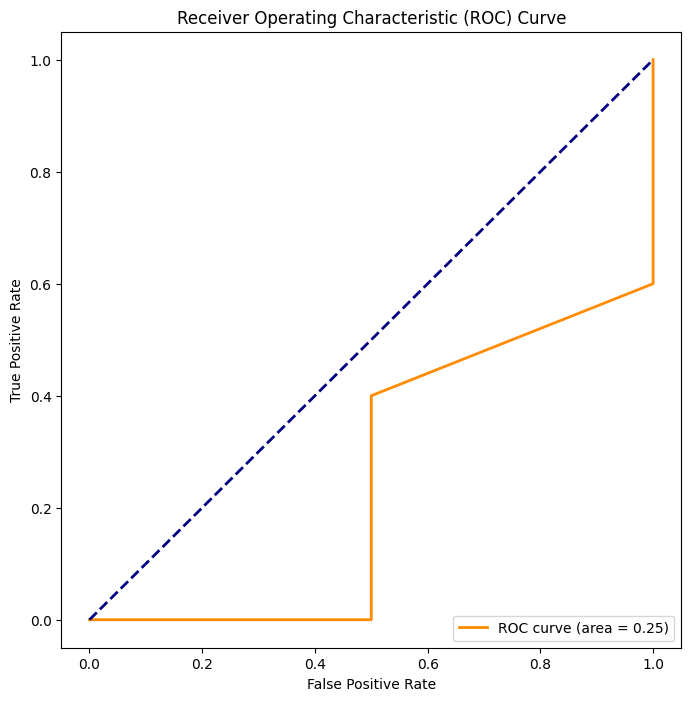

In [87]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example data
normalized_distances = np.array([0.1, 0.2, 0.15, 0.25, 0.3, 0.8, 1.0])
labels = np.array([1, 1, 1, 1, 1, 0, 0])

# Invert the distances for positive instances to make them smaller
normalized_distances[labels == 1] = 1.0 - normalized_distances[labels == 1]

# Sort the data by distances
sorted_data = sorted(zip(normalized_distances, labels), key=lambda x: x[0])
sorted_distances, sorted_labels = zip(*sorted_data)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_distances)
roc_auc = auc(fpr, tpr)

# Print results
print("Sorted Distances:", sorted_distances)
print("Sorted Labels:", sorted_labels)
print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)
print("ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



Signature: 001
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


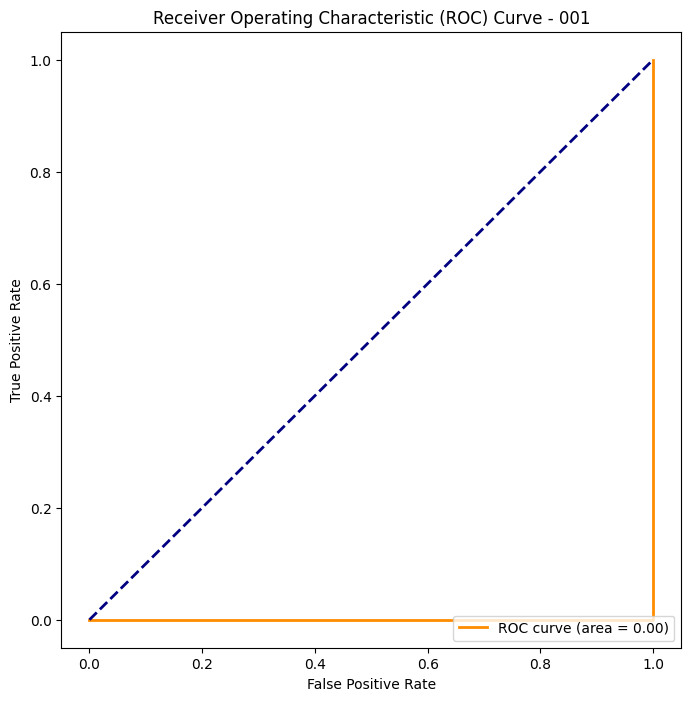


Signature: 002
FPR: [0.         0.33333333 0.33333333 1.         1.        ]
TPR: [0.  0.  0.2 0.2 1. ]
AUC: 0.13333333333333336


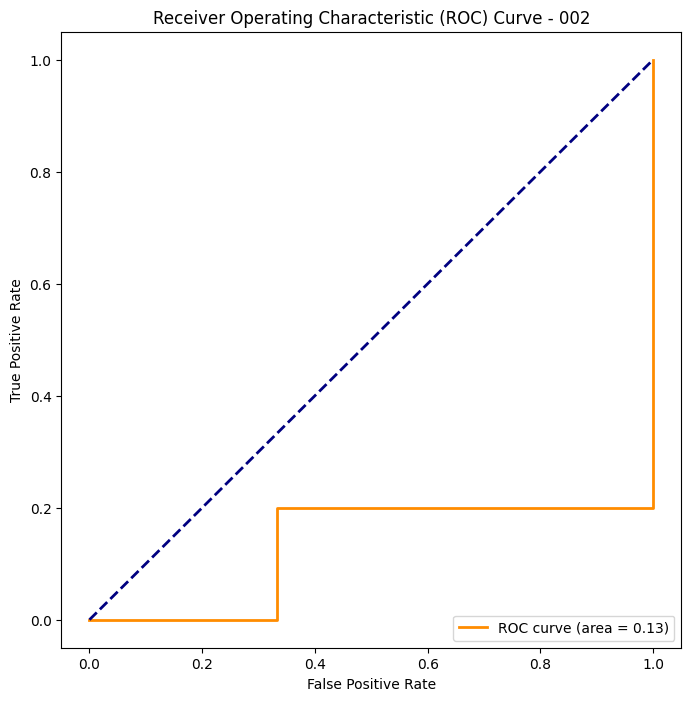


Signature: 003
FPR: [0.         0.33333333 0.66666667 0.66666667 1.         1.        ]
TPR: [0.  0.  0.  0.4 0.4 1. ]
AUC: 0.13333333333333336


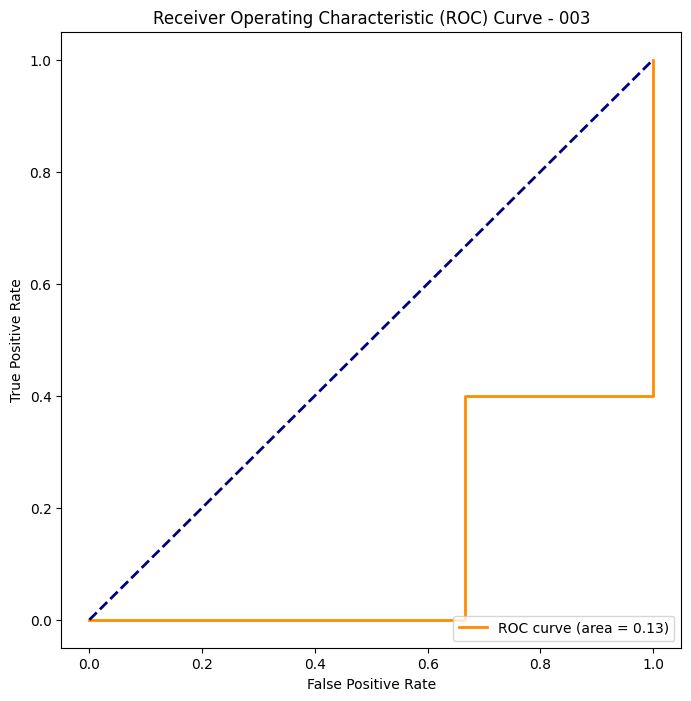


Signature: 004
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


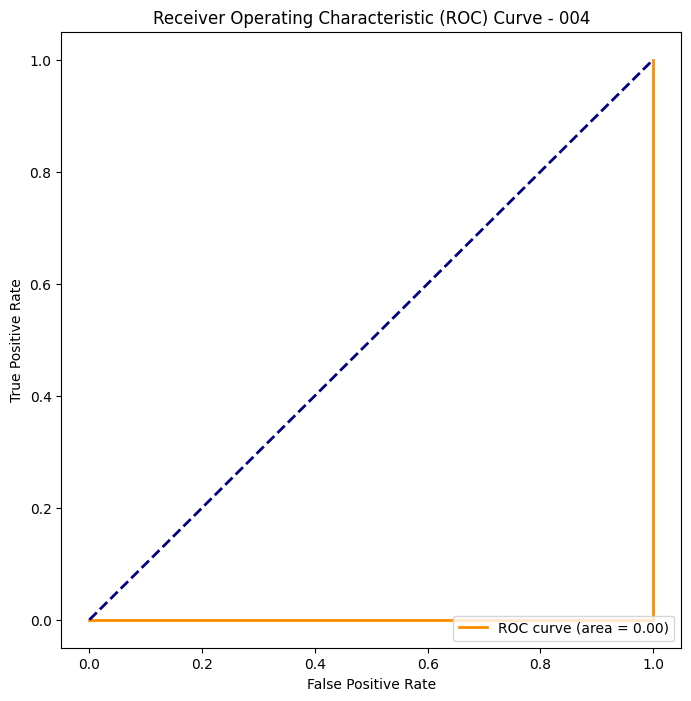


Signature: 006
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


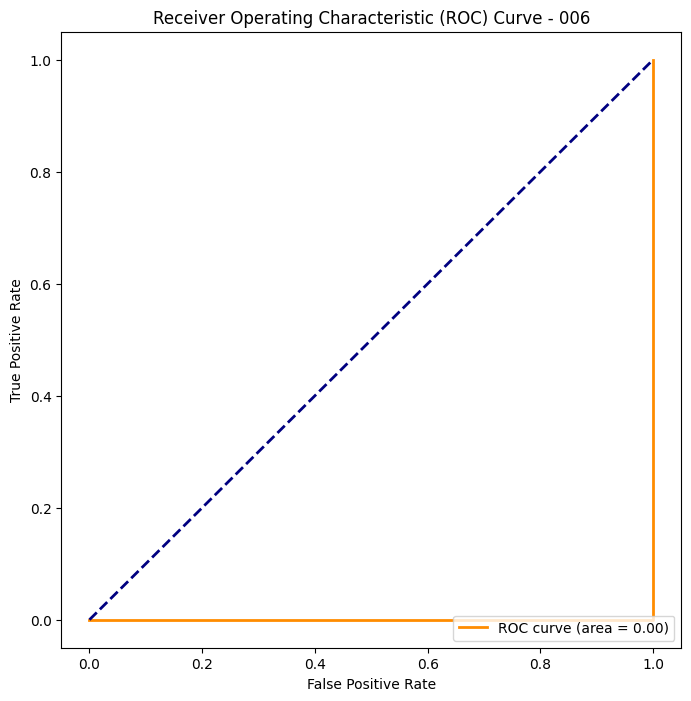


Signature: 009
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


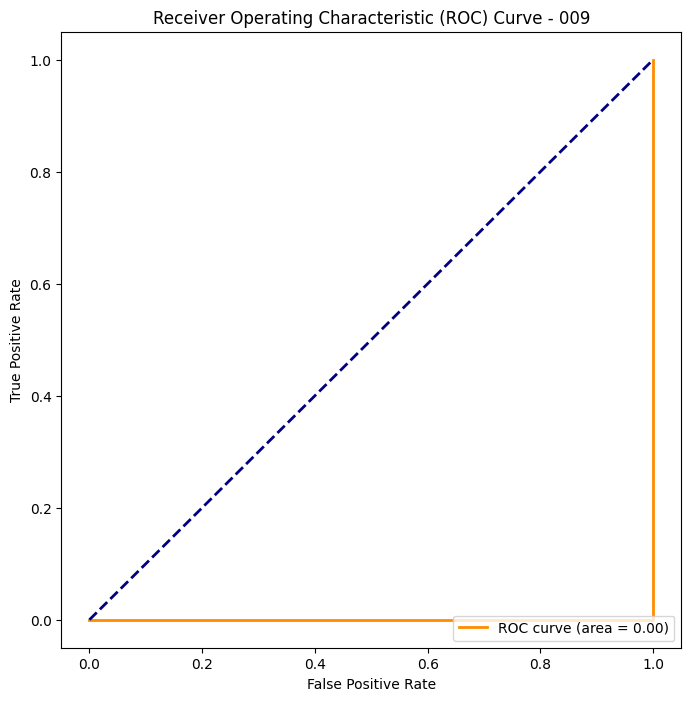


Signature: 012
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


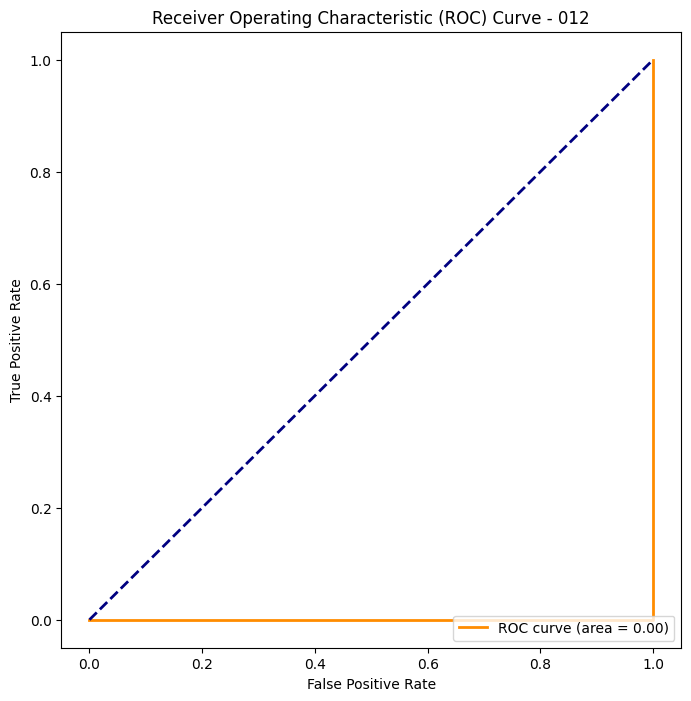


Signature: 013
FPR: [0.         0.33333333 0.66666667 0.66666667 1.         1.        ]
TPR: [0.         0.         0.         0.33333333 0.33333333 1.        ]
AUC: 0.11111111111111112


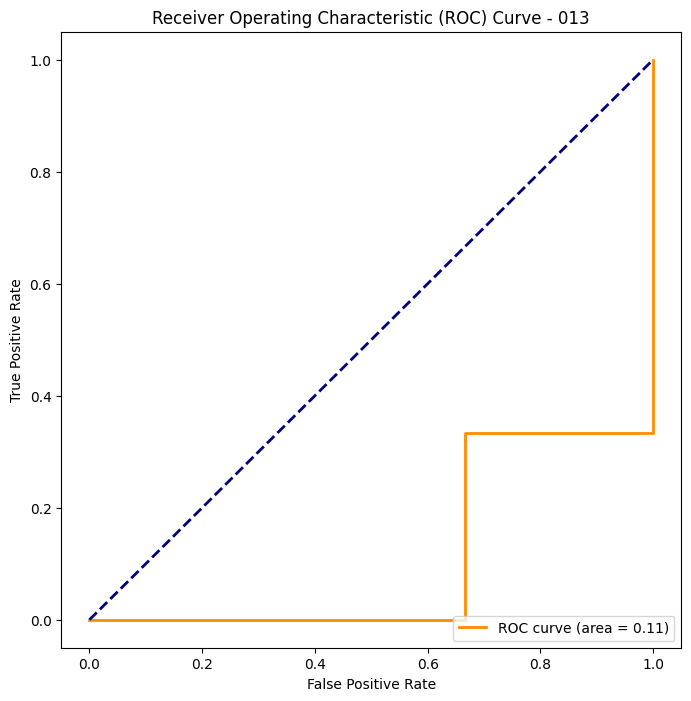


Signature: 014
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


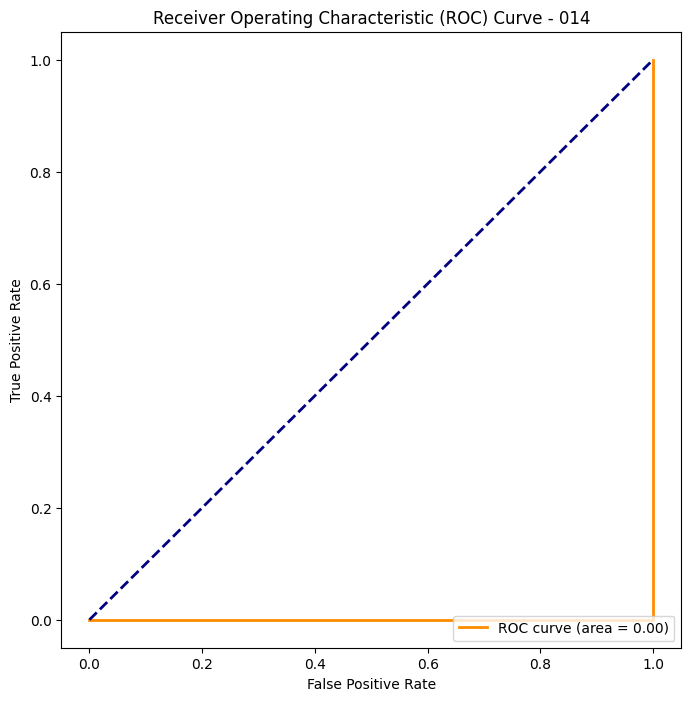


Signature: 015
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


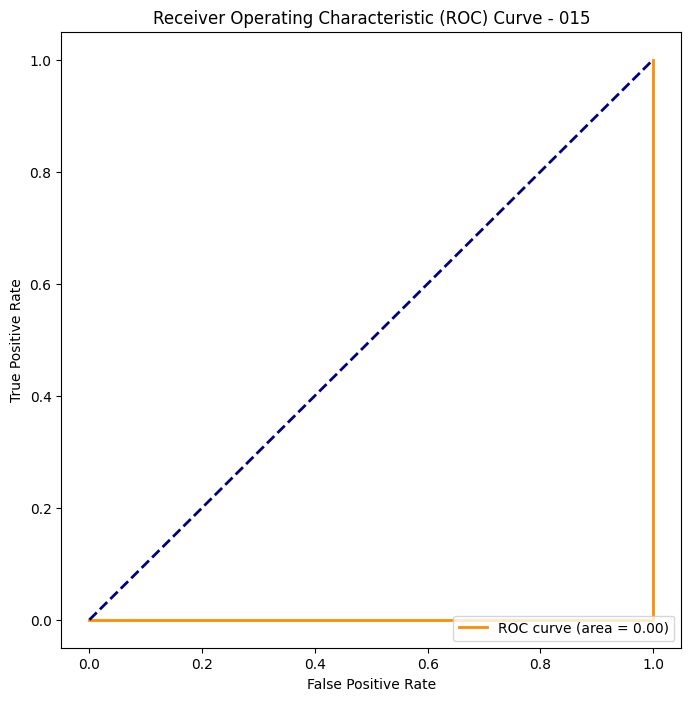


Signature: 016
FPR: [0.   0.25 0.75 0.75 1.   1.  ]
TPR: [0.  0.  0.  0.4 0.4 1. ]
AUC: 0.1


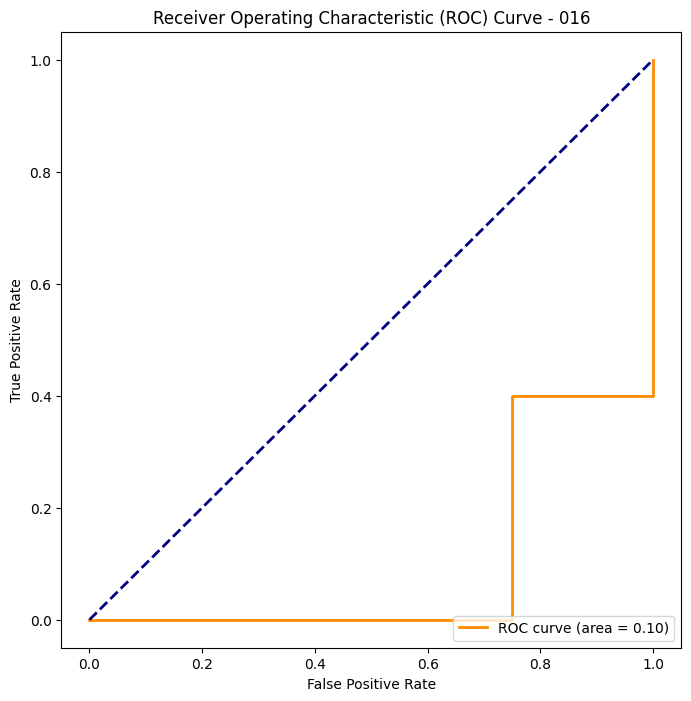


Signature: 017
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


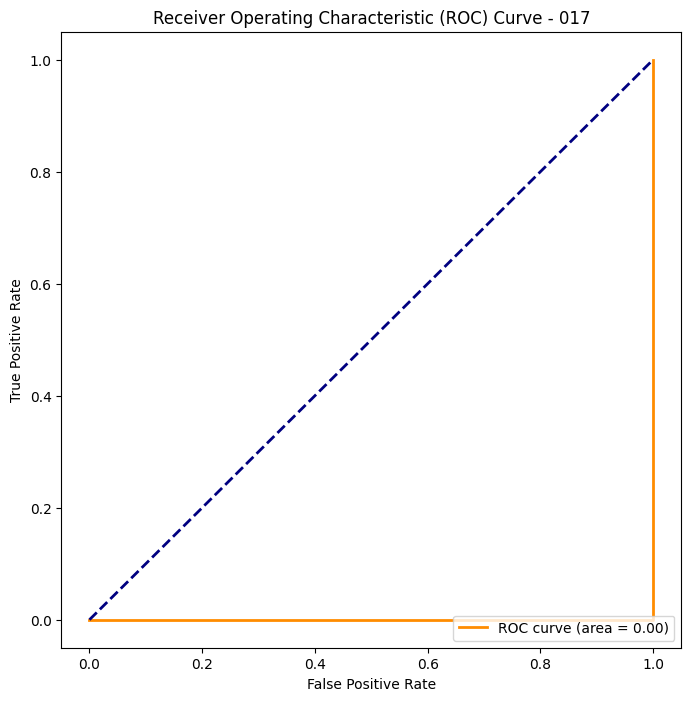


Signature: 018
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


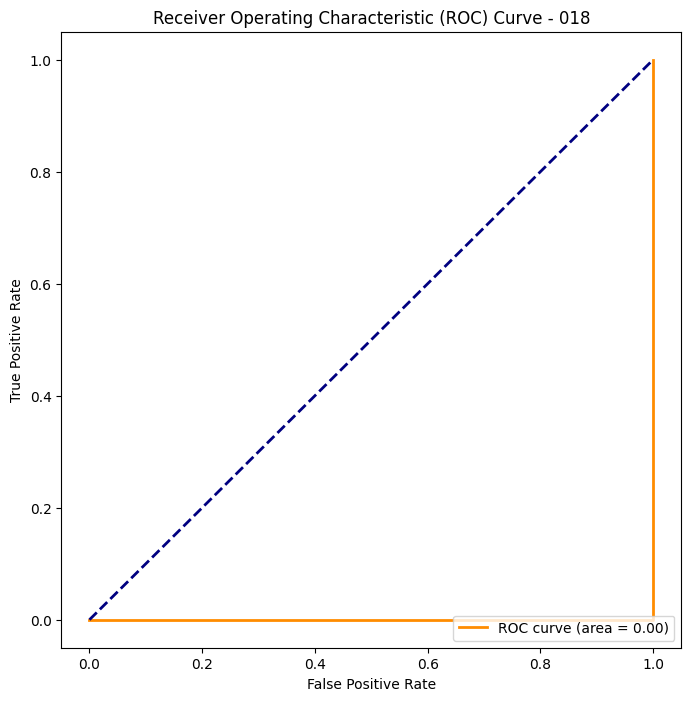


Signature: 019
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


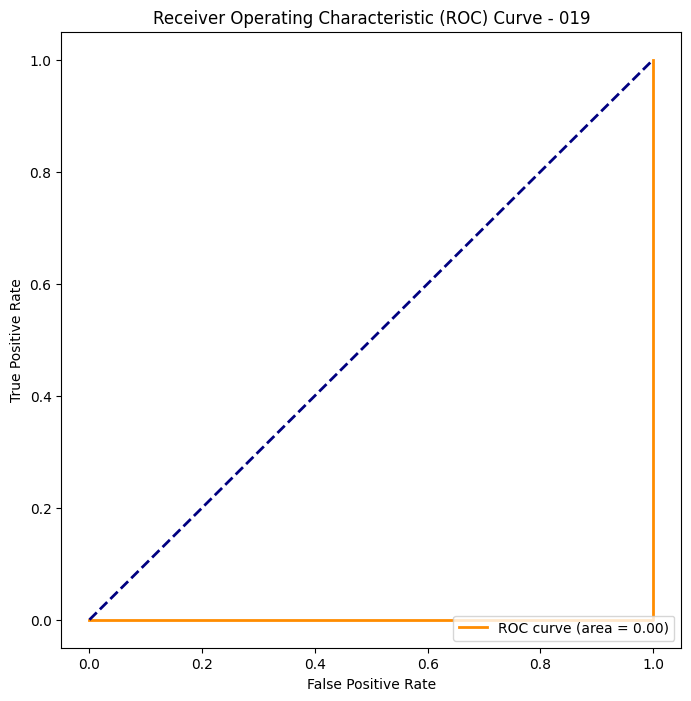


Signature: 020
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


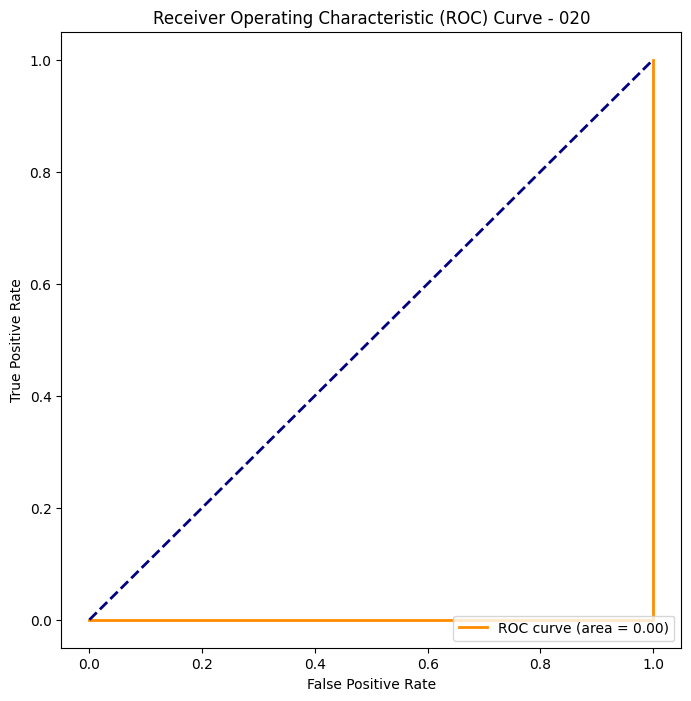


Signature: 021
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


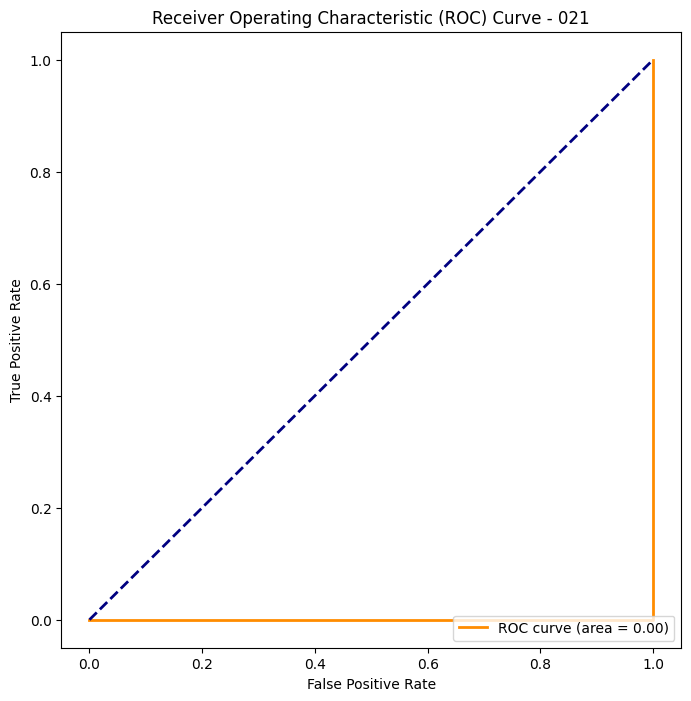


Signature: 022
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


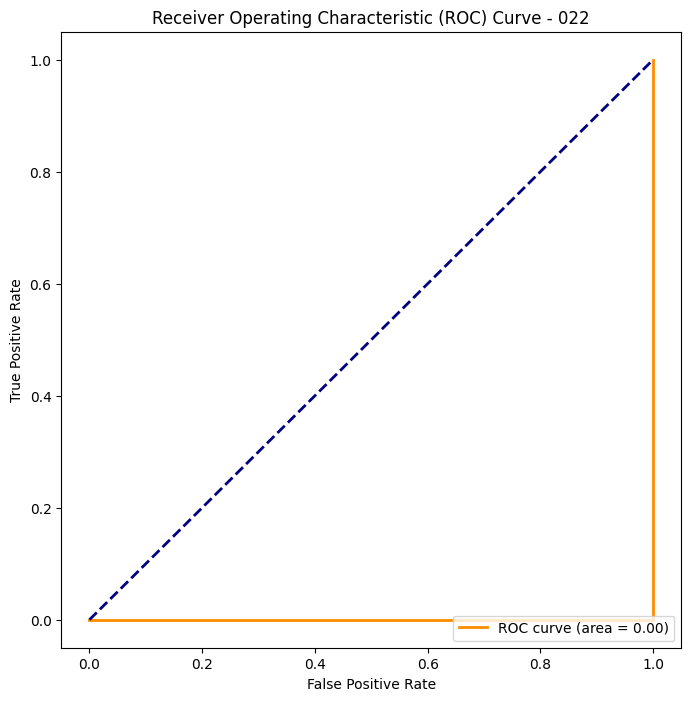


Signature: 023
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


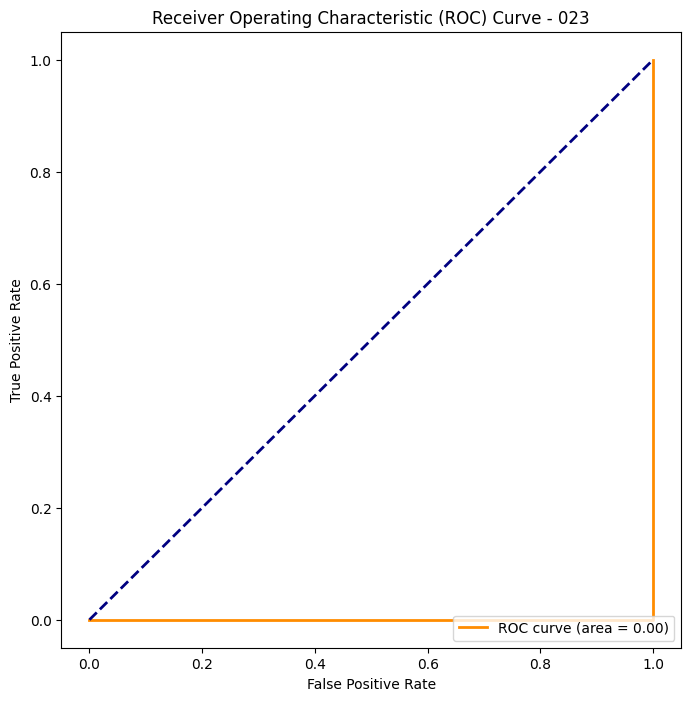


Signature: 024
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


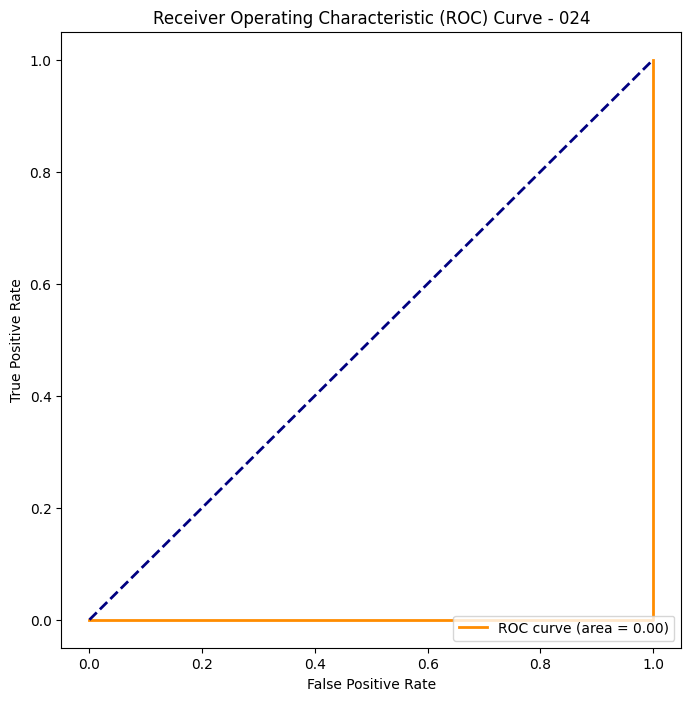


Signature: 025
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


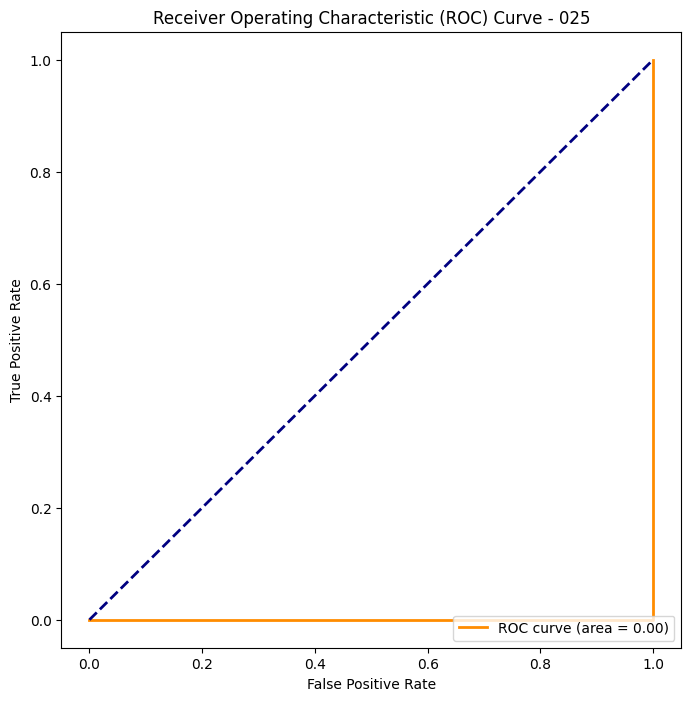


Signature: 026
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


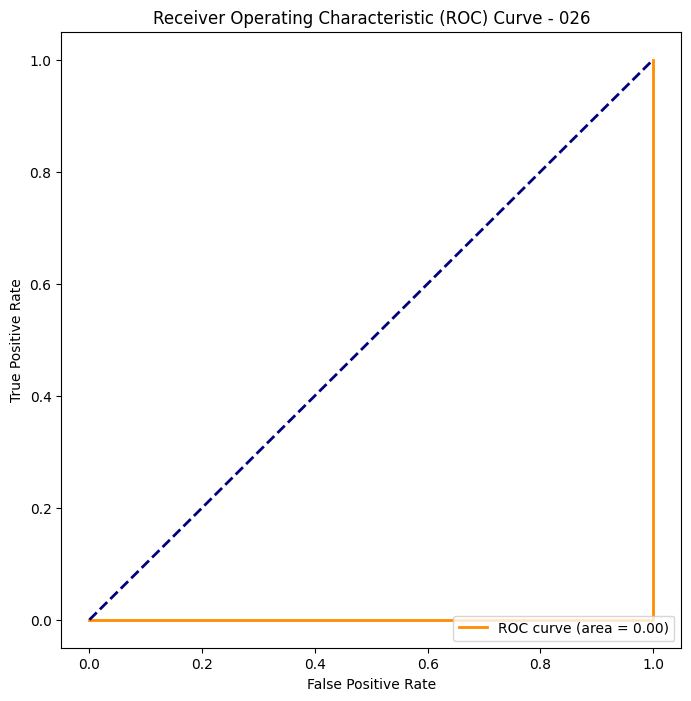


Signature: 027
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


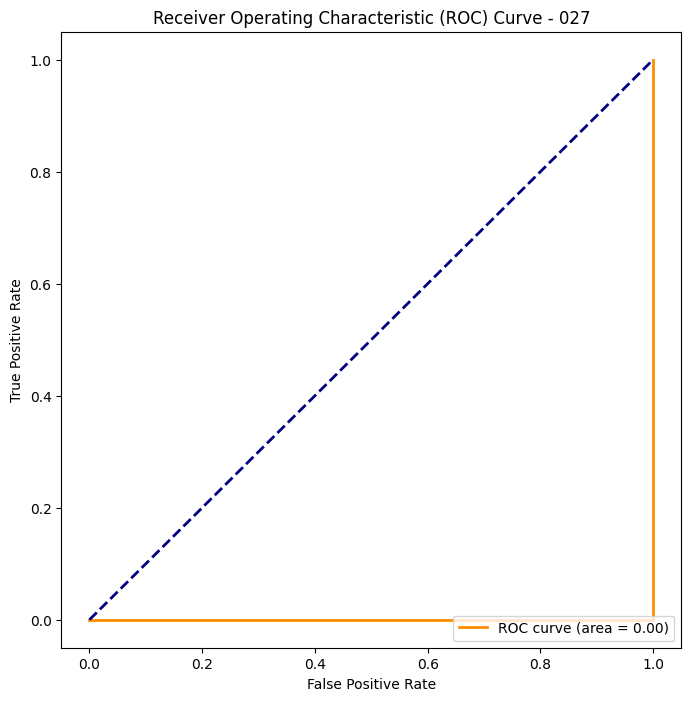


Signature: 028
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


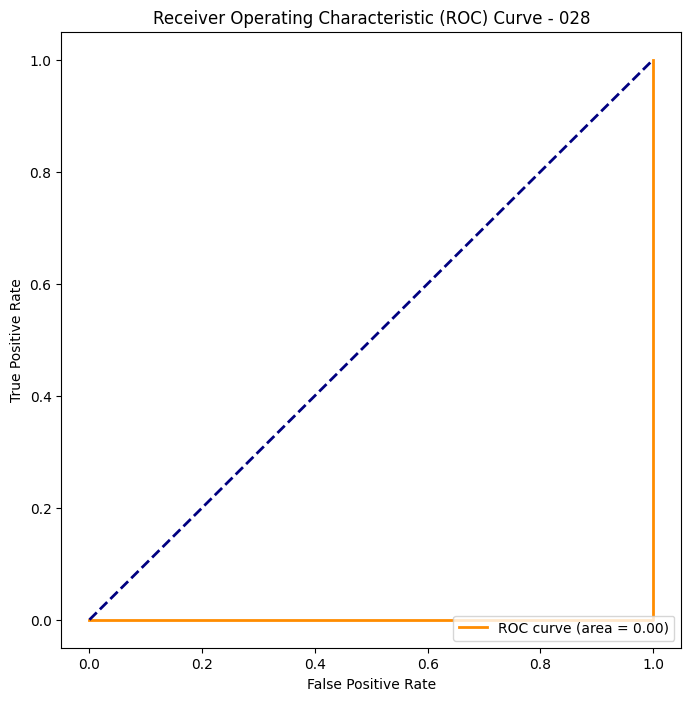


Signature: 029
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


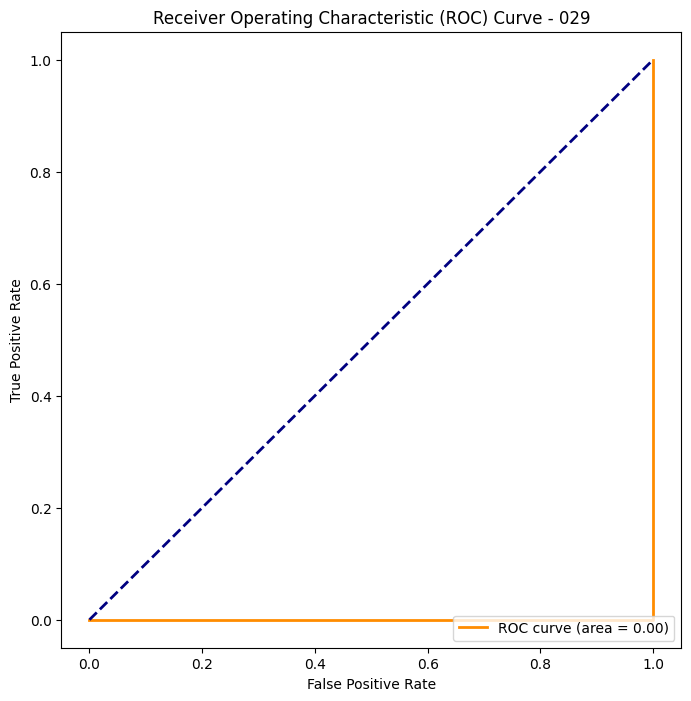


Signature: 030
FPR: [0. 0. 1. 1.]
TPR: [0.         0.33333333 0.33333333 1.        ]
AUC: 0.3333333333333333


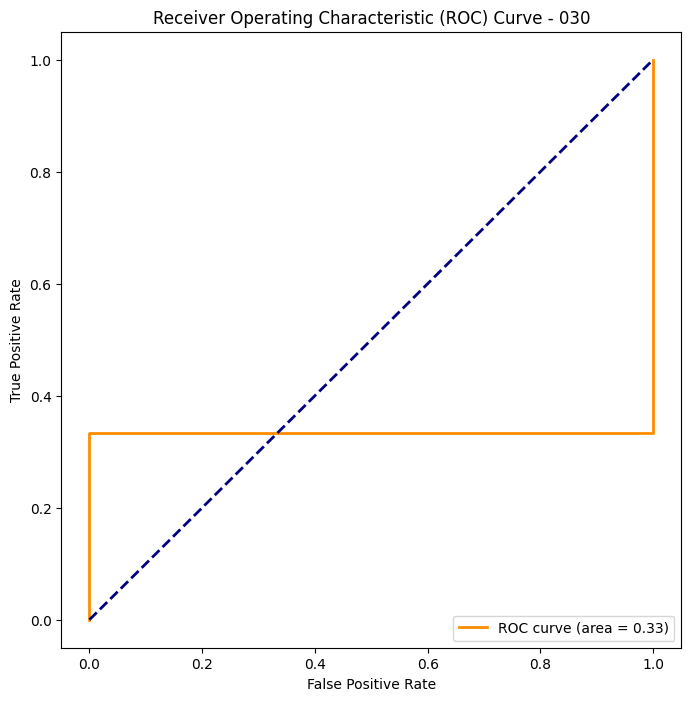


Signature: 031
FPR: [0.  0.5 0.5 1.  1. ]
TPR: [0.         0.         0.33333333 0.33333333 1.        ]
AUC: 0.16666666666666666


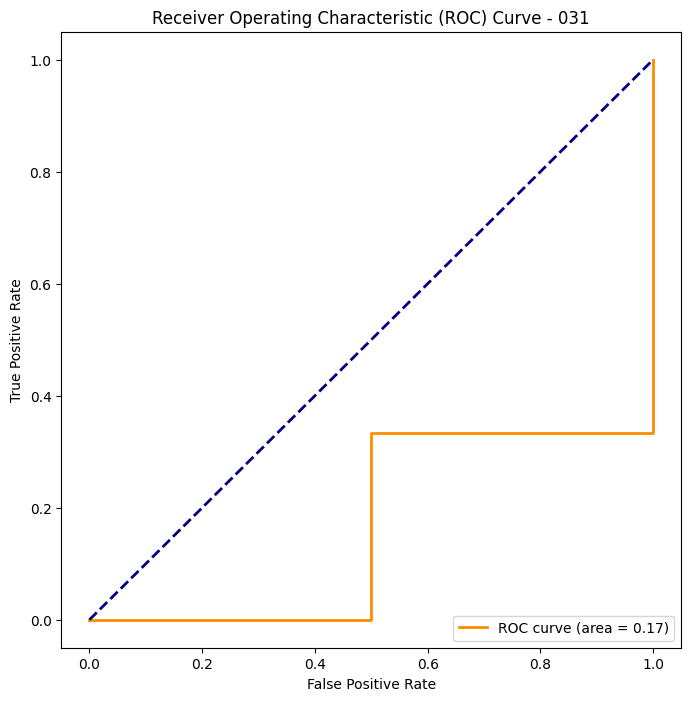


Signature: 032
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


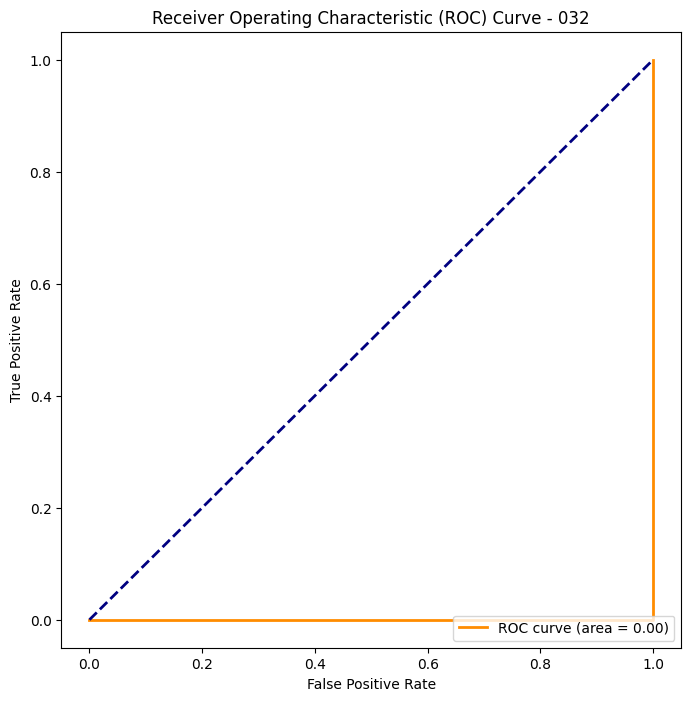


Signature: 033
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


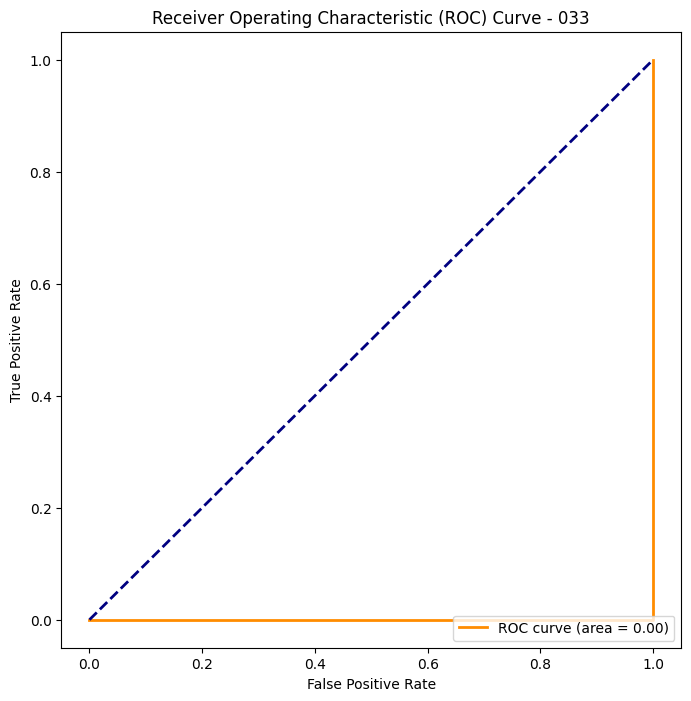


Signature: 034
FPR: [0.         0.33333333 0.66666667 0.66666667 1.         1.        ]
TPR: [0.         0.         0.         0.33333333 0.33333333 1.        ]
AUC: 0.11111111111111112


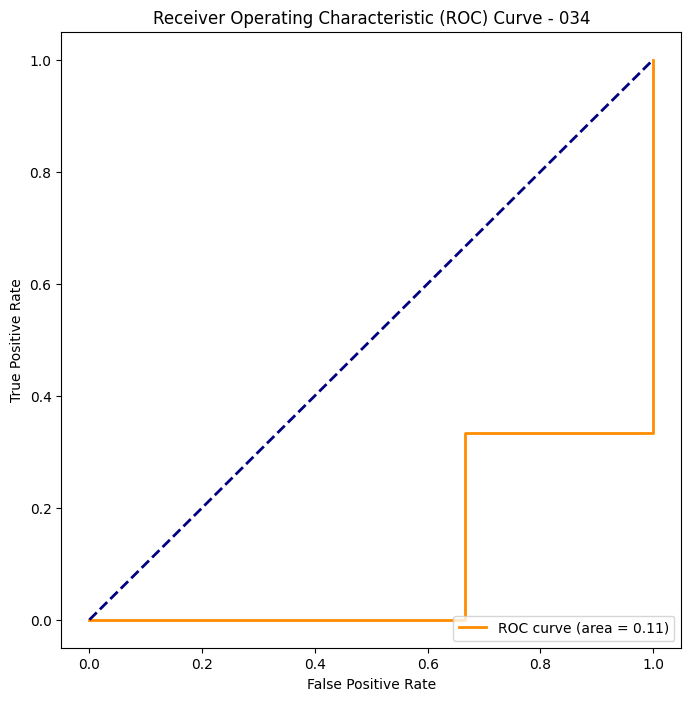


Signature: 035
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


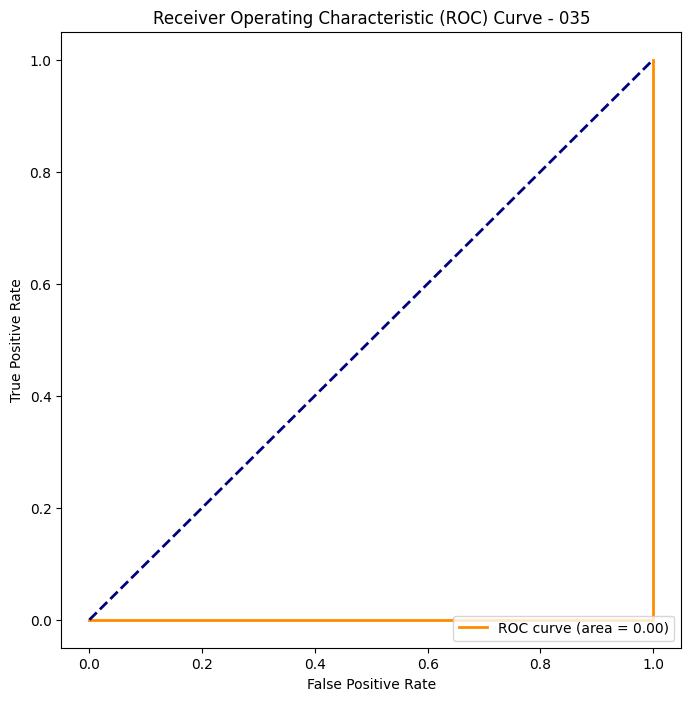


Signature: 036
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


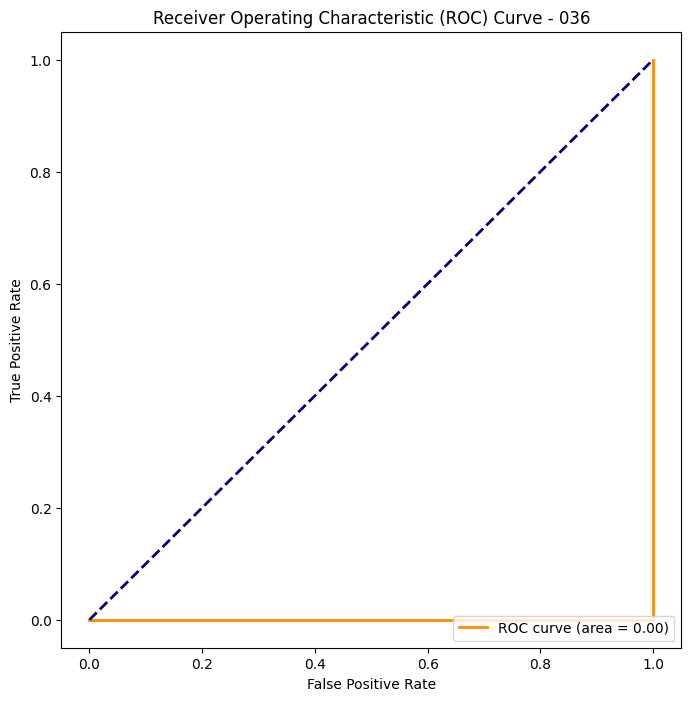


Signature: 037
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


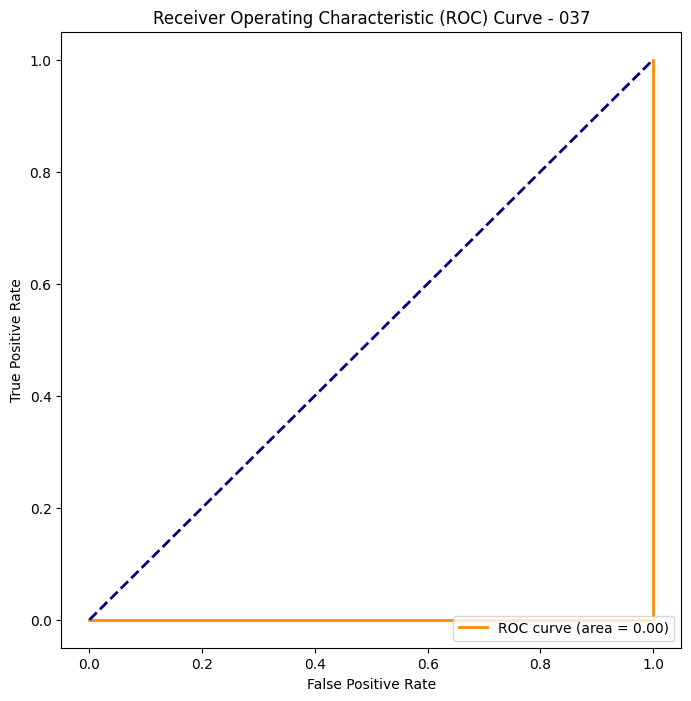


Signature: 038
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


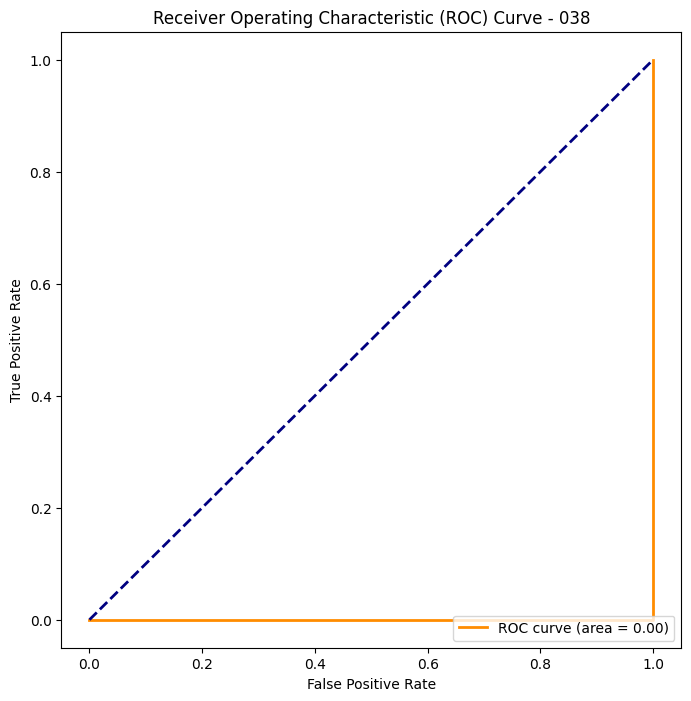


Signature: 039
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


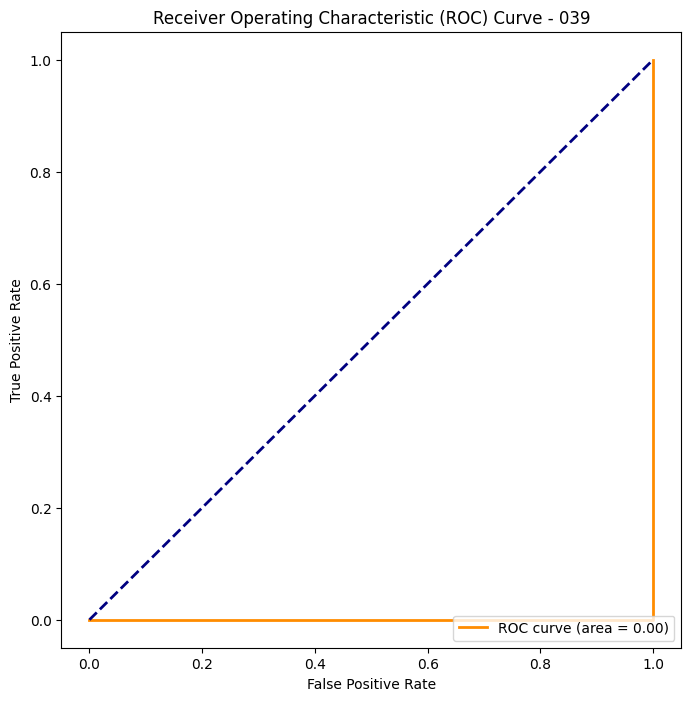


Signature: 040
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


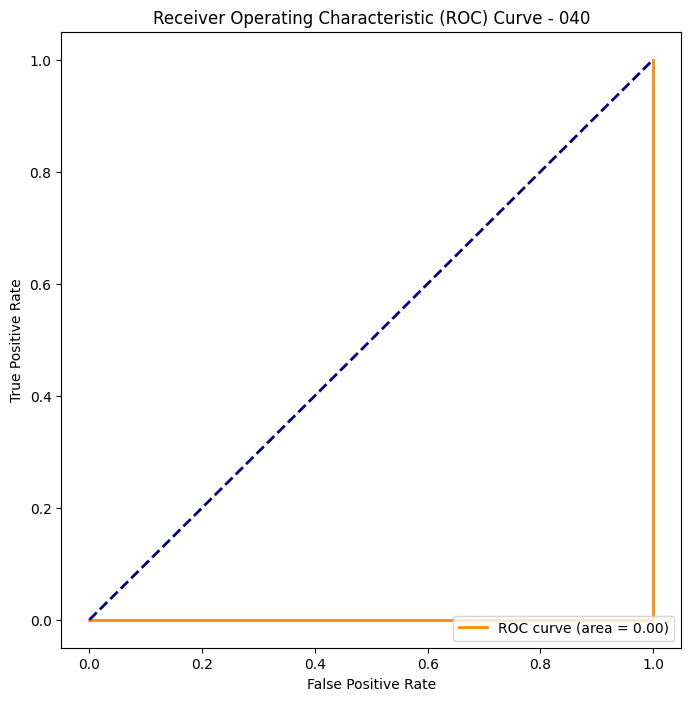


Signature: 041
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


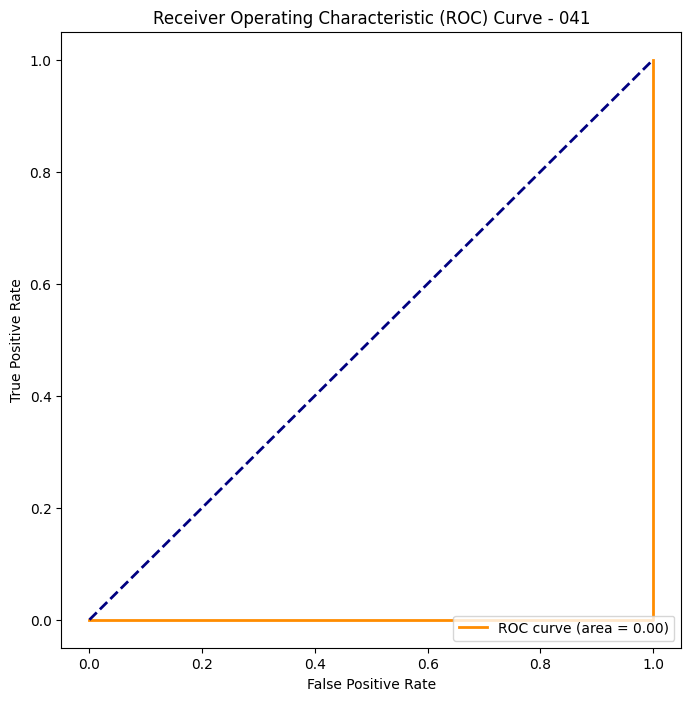


Signature: 042
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


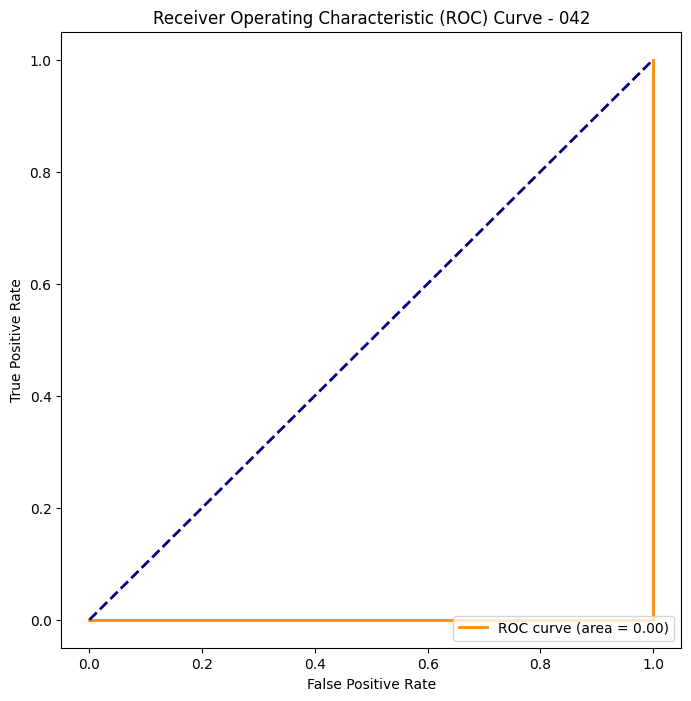


Signature: 043
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


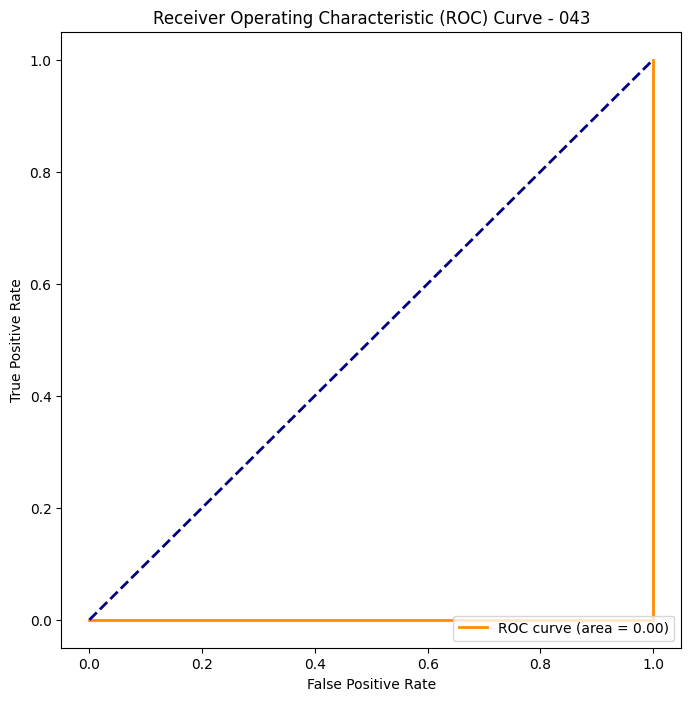


Signature: 044
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


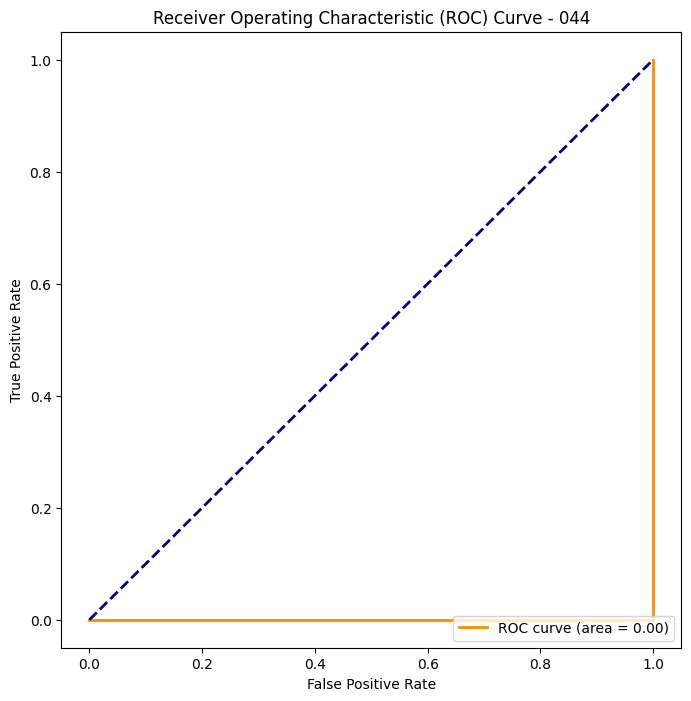


Signature: 045
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


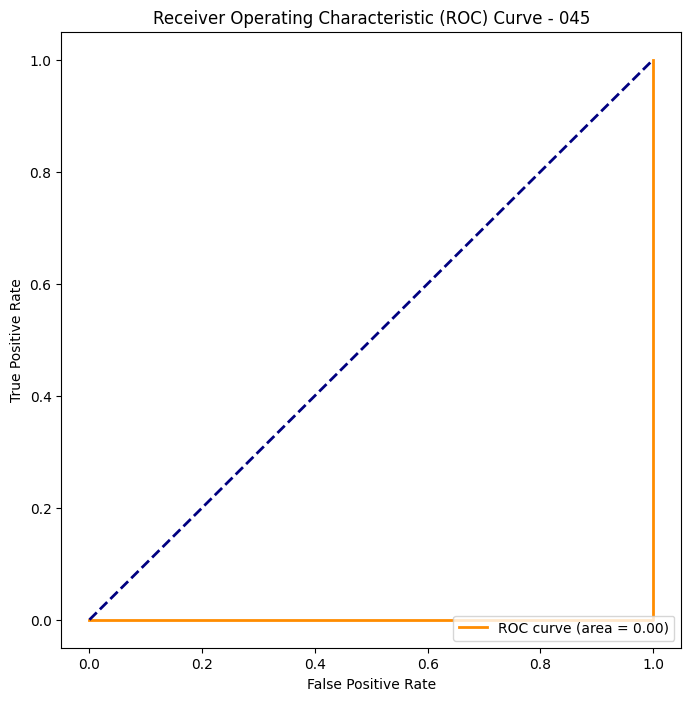


Signature: 046
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


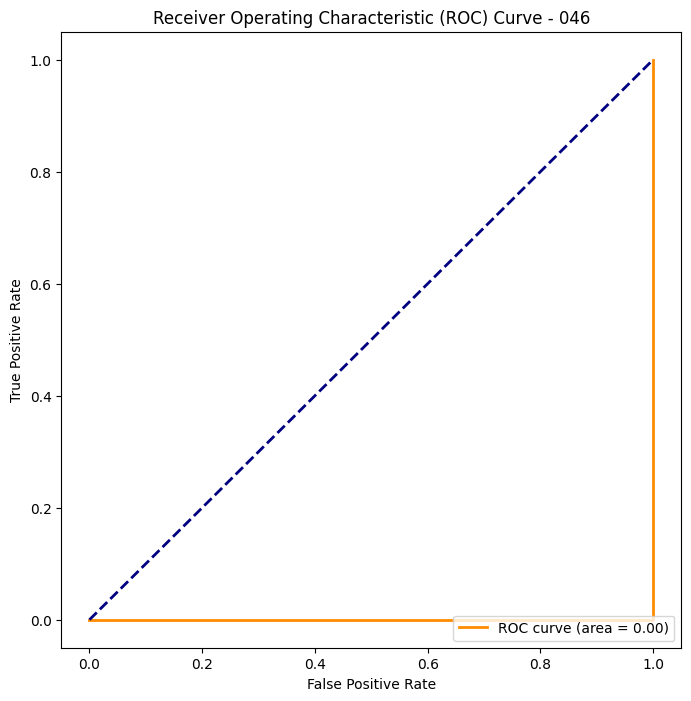


Signature: 047
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


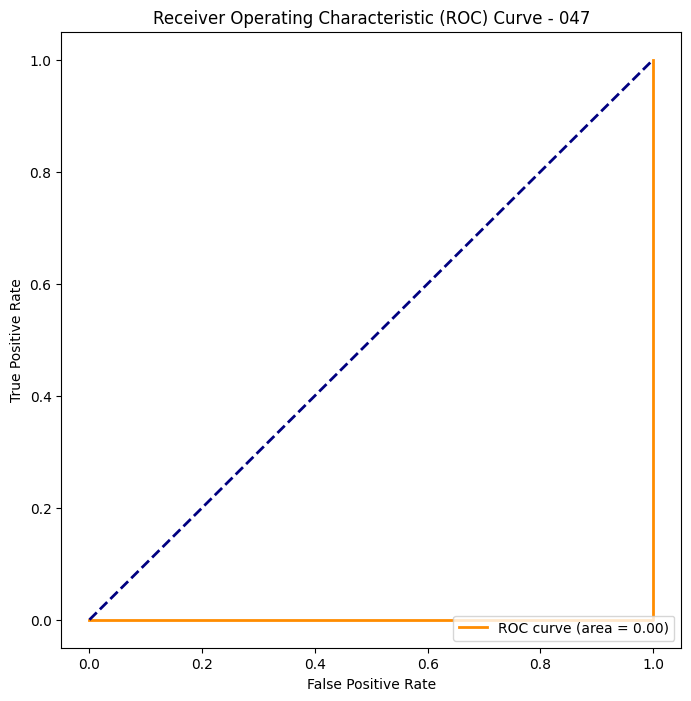


Signature: 048
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


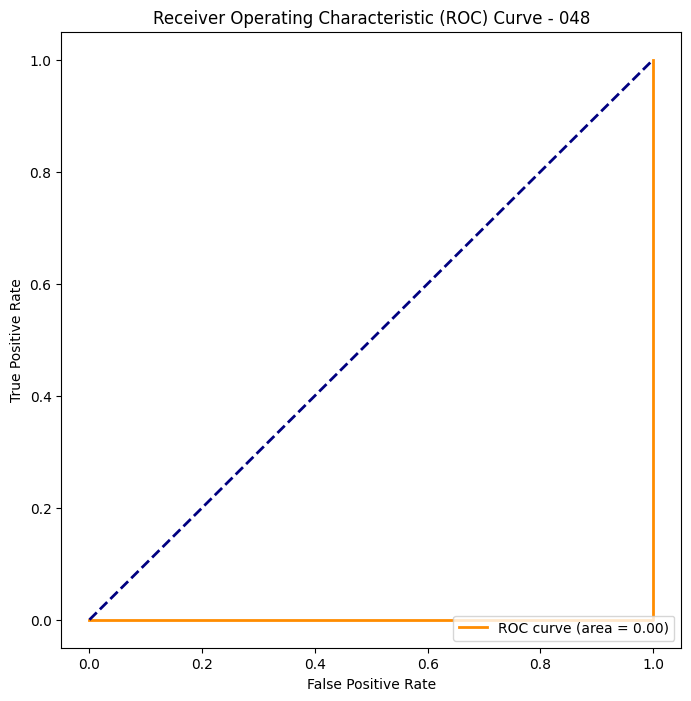


Signature: 049
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


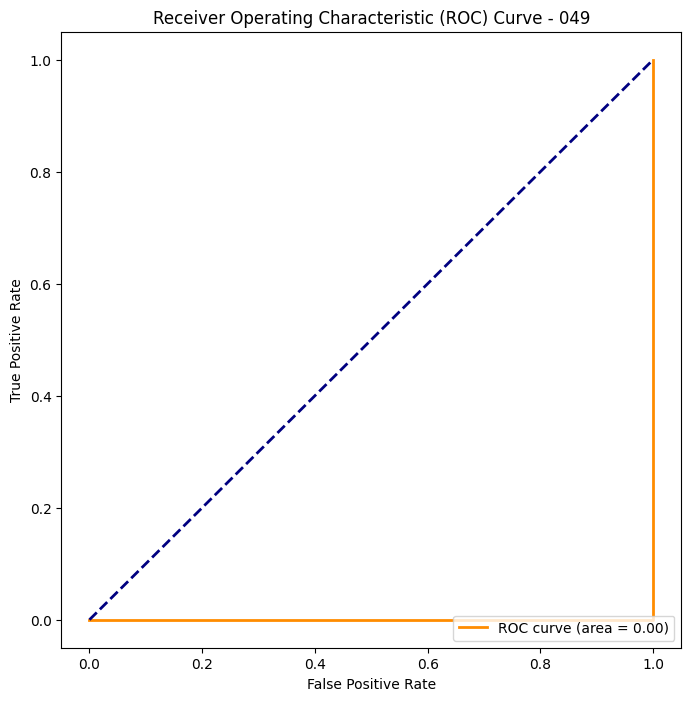


Signature: 050
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


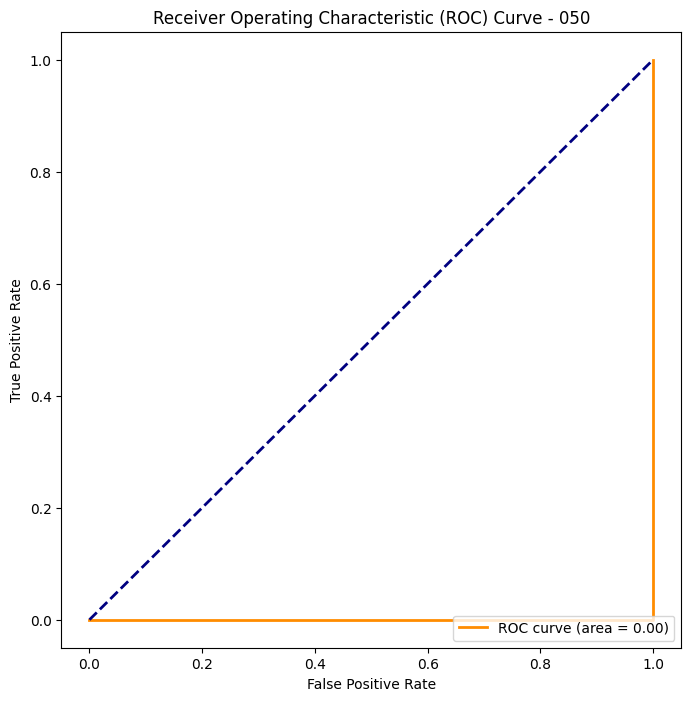


Signature: 051
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


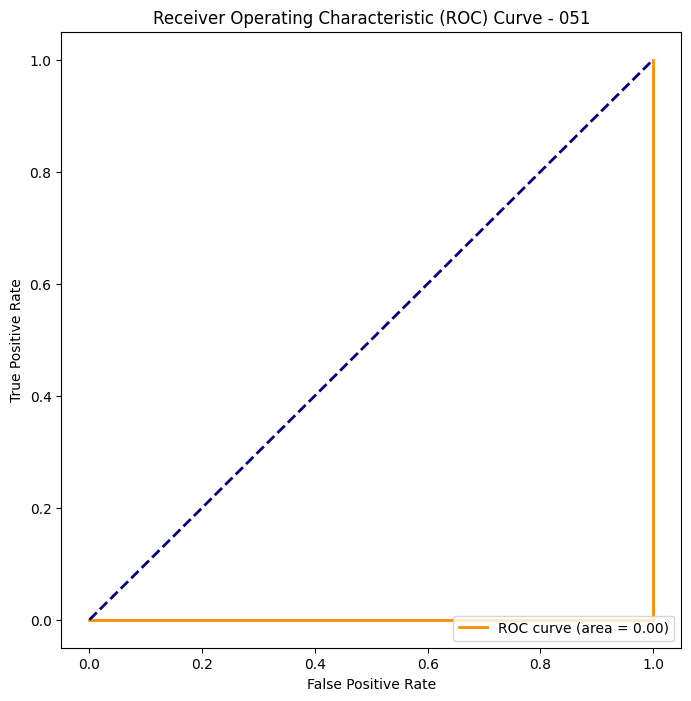


Signature: 052
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


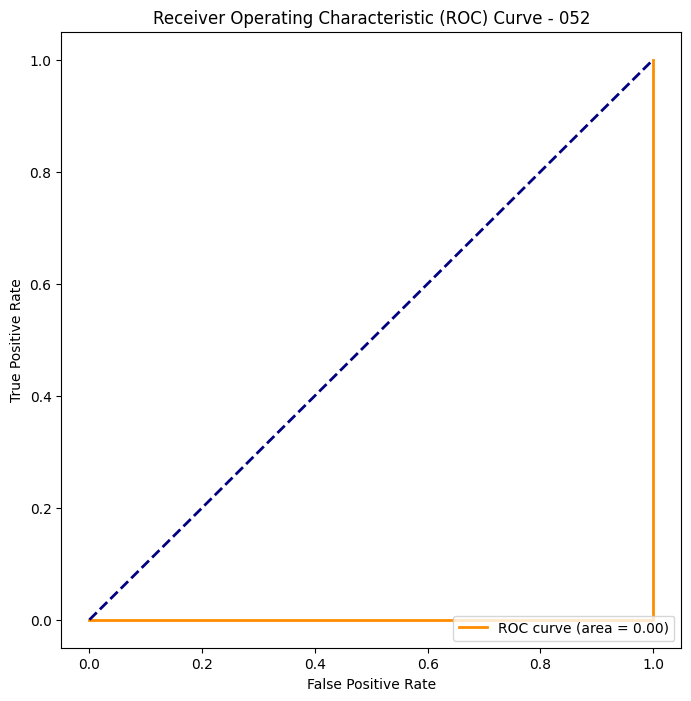


Signature: 053
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


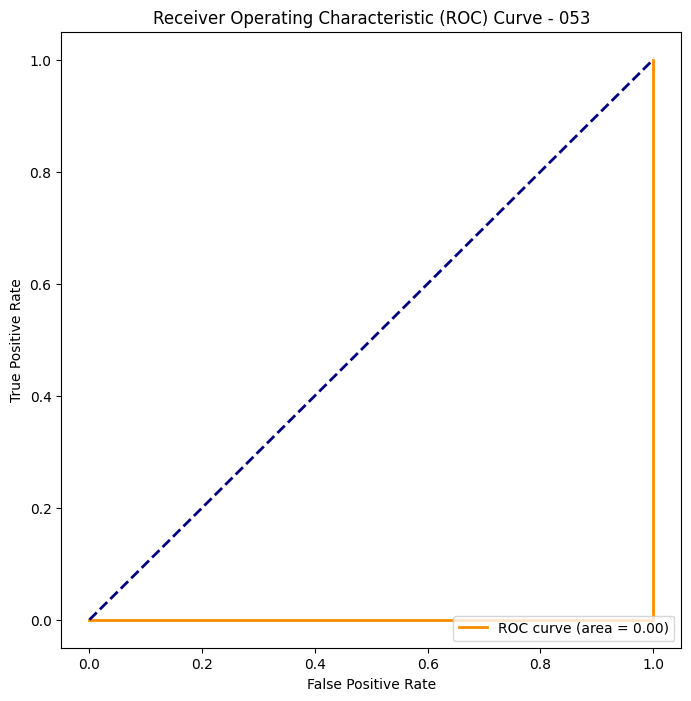


Signature: 054
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


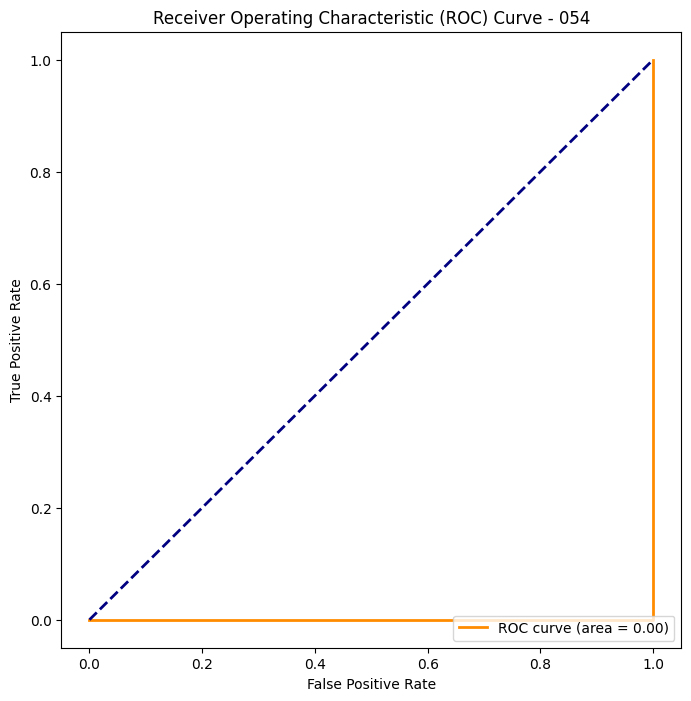


Signature: 055
FPR: [0. 0. 1. 1.]
TPR: [0.         0.33333333 0.33333333 1.        ]
AUC: 0.3333333333333333


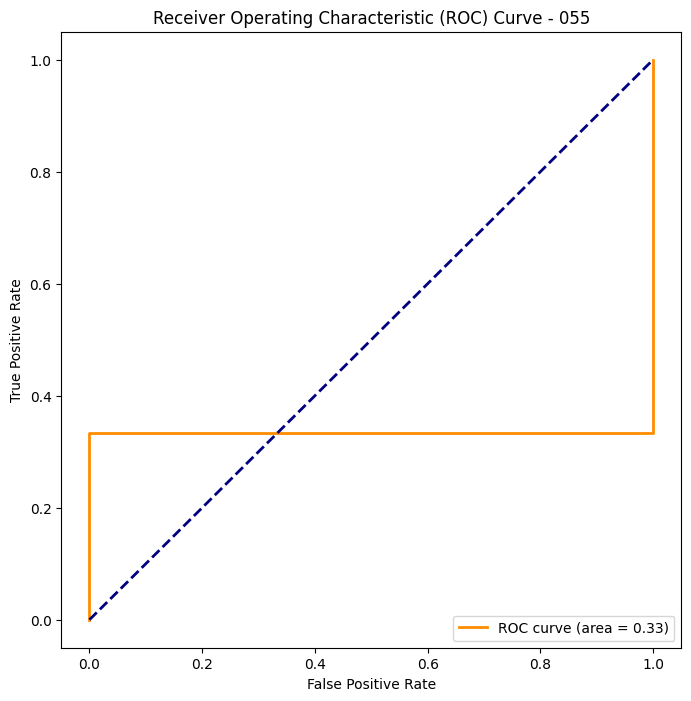


Signature: 056
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


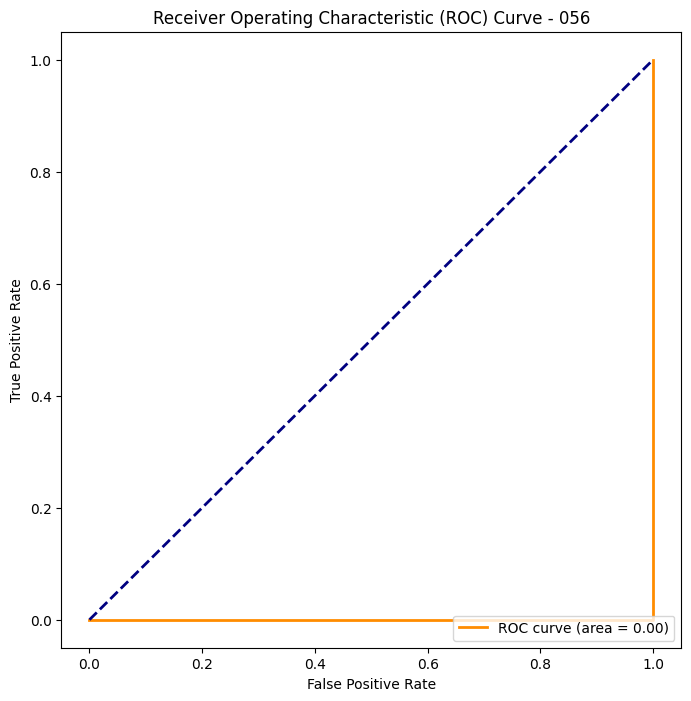


Signature: 057
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


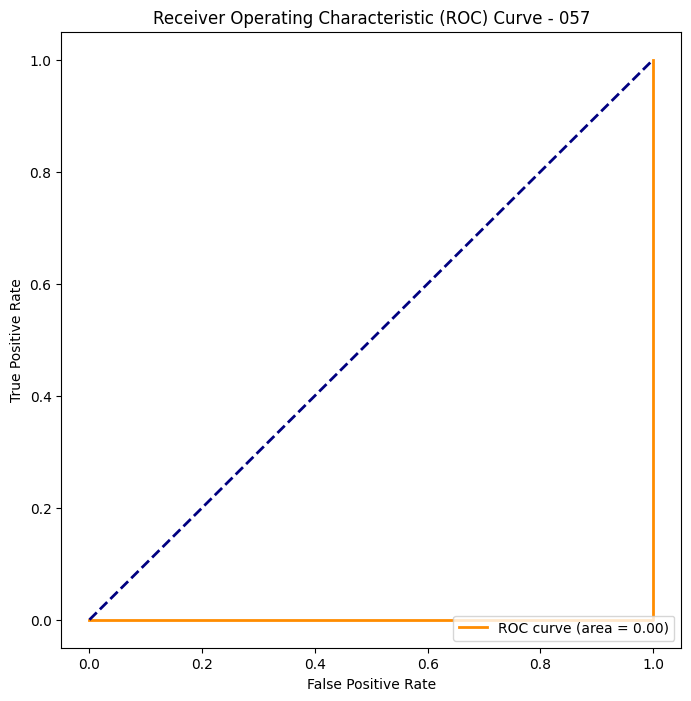


Signature: 058
FPR: [0.   0.25 1.   1.  ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


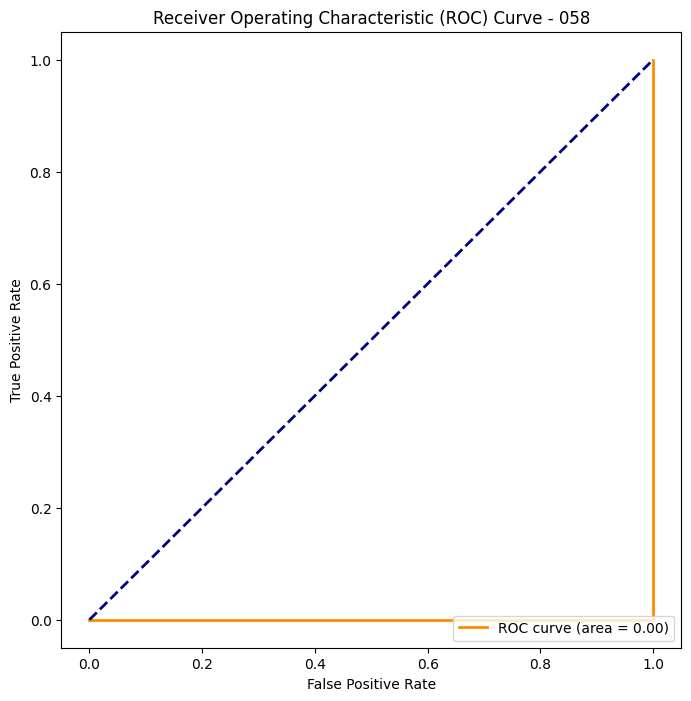


Signature: 059
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


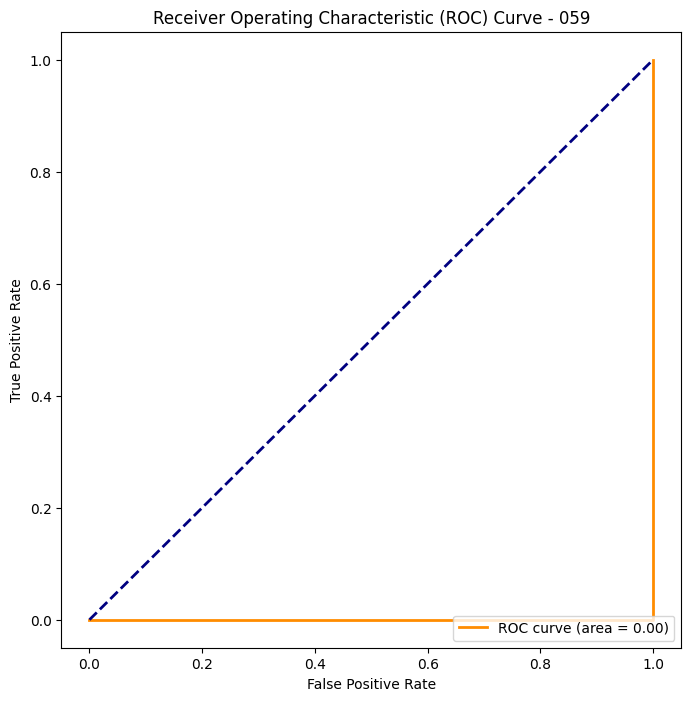


Signature: 060
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


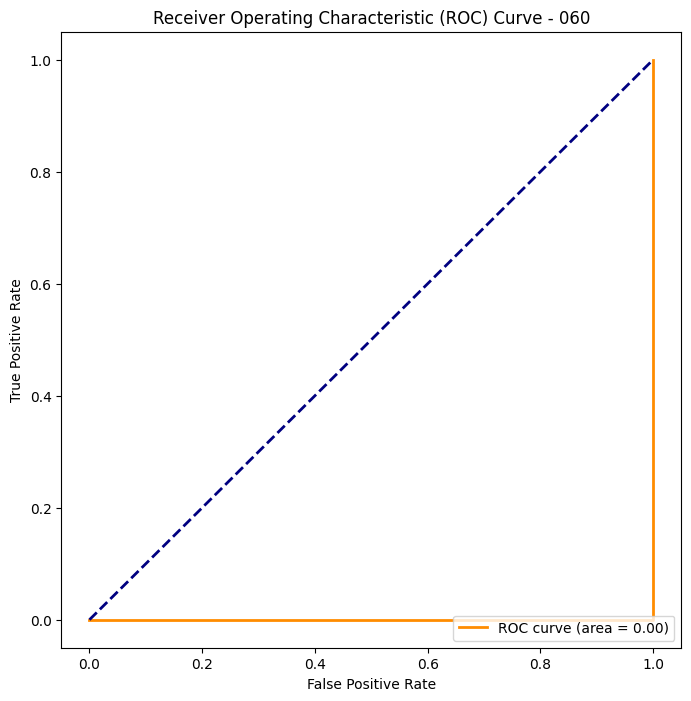


Signature: 061
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


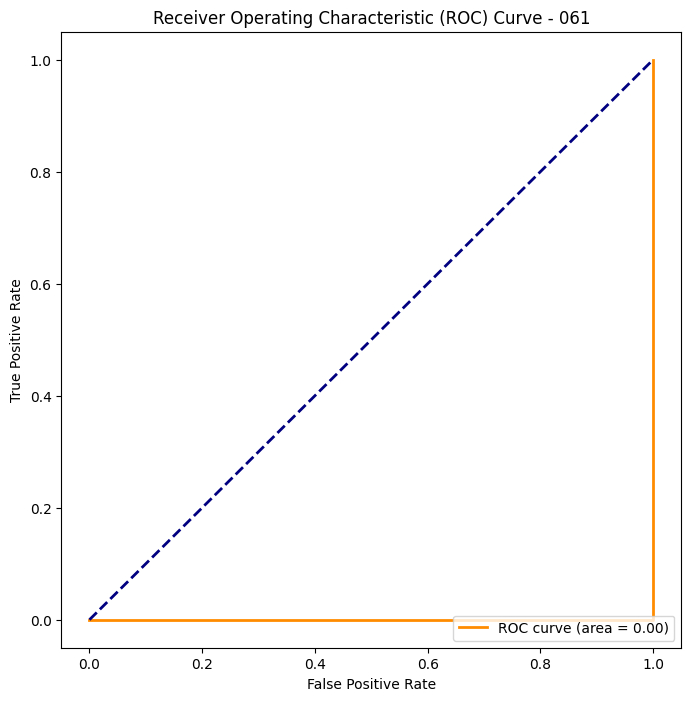


Signature: 062
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


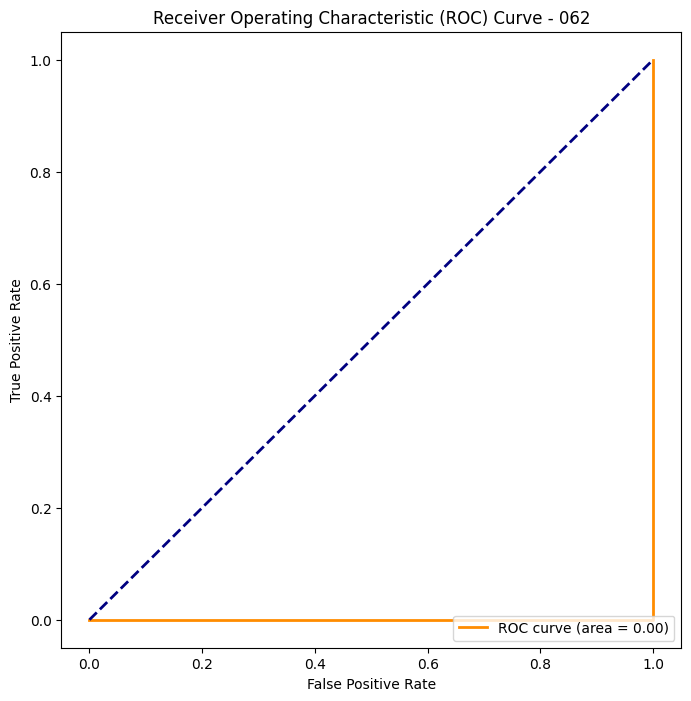


Signature: 063
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


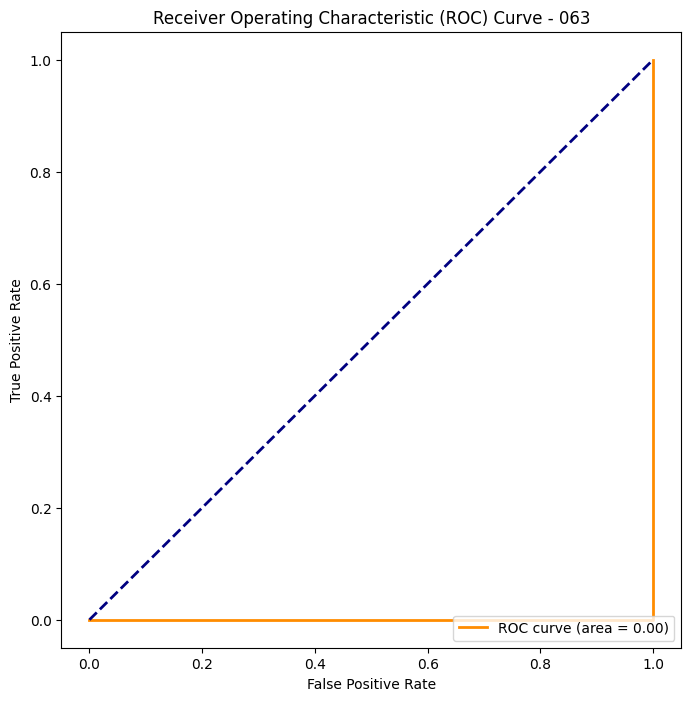


Signature: 064
FPR: [0.  0.5 0.5 1.  1. ]
TPR: [0.         0.         0.33333333 0.33333333 1.        ]
AUC: 0.16666666666666666


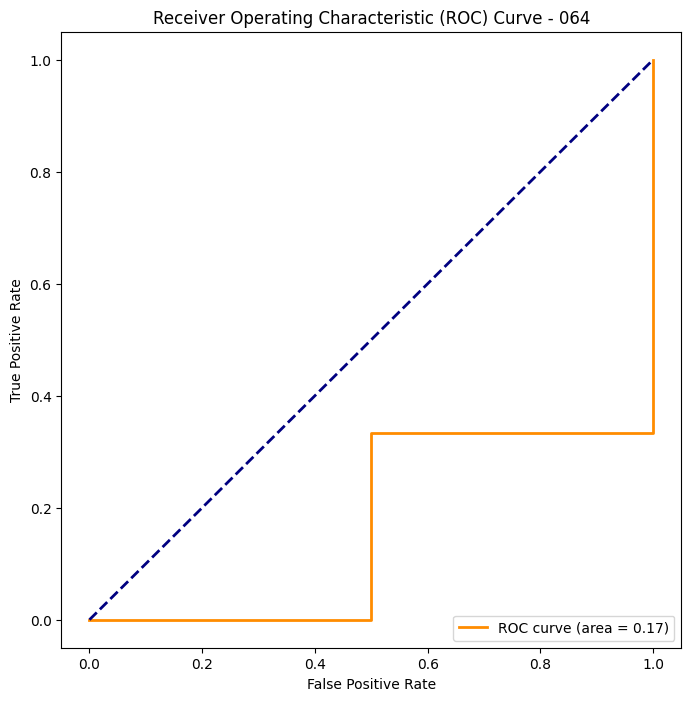


Signature: 065
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


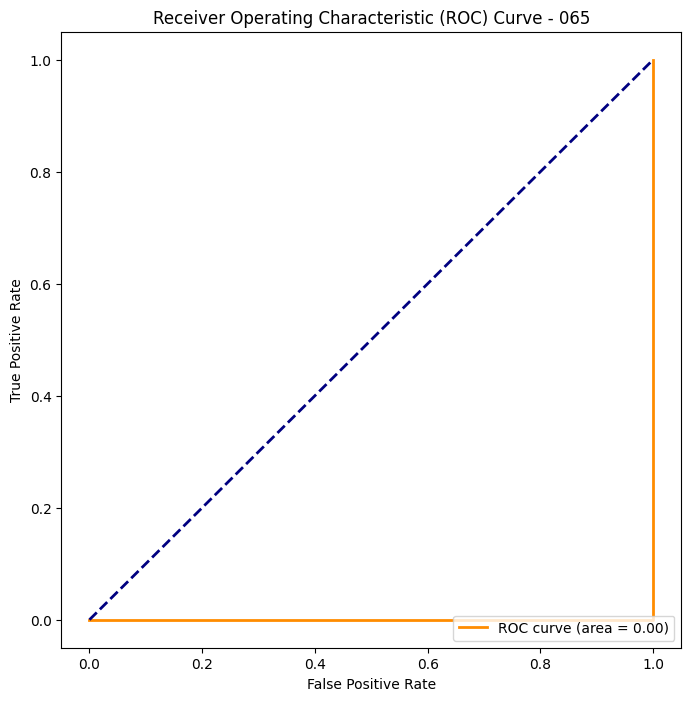


Signature: 066
FPR: [0.   0.25 0.75 0.75 1.   1.  ]
TPR: [0.         0.         0.         0.33333333 0.33333333 1.        ]
AUC: 0.08333333333333333


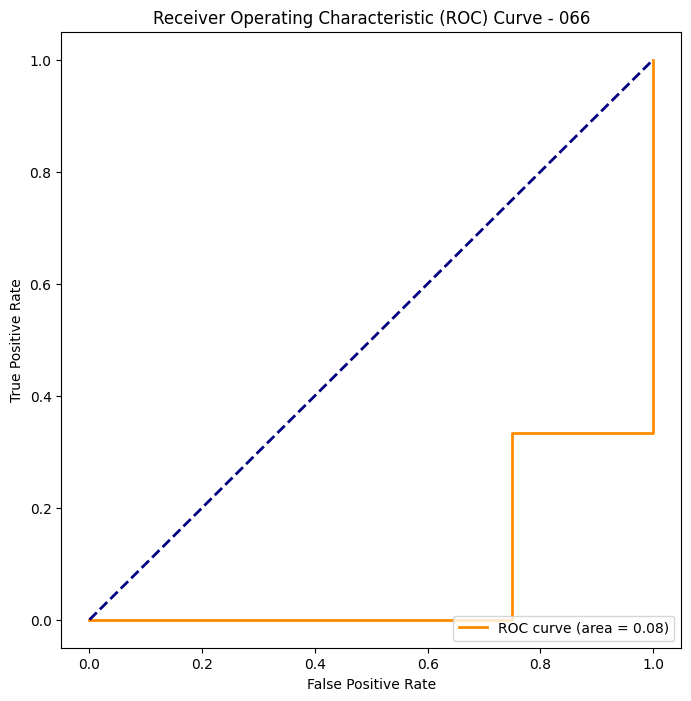


Signature: 067
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


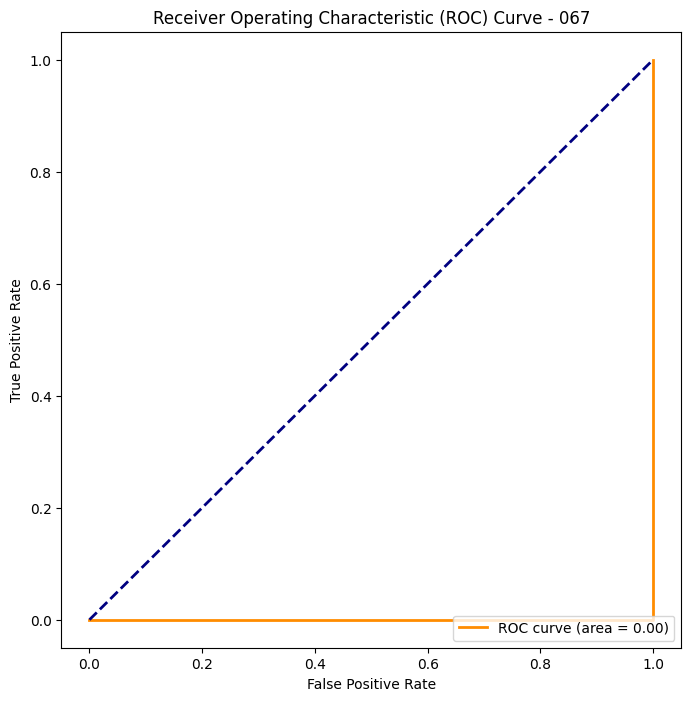


Signature: 068
FPR: [0.  0.5 1.  1. ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


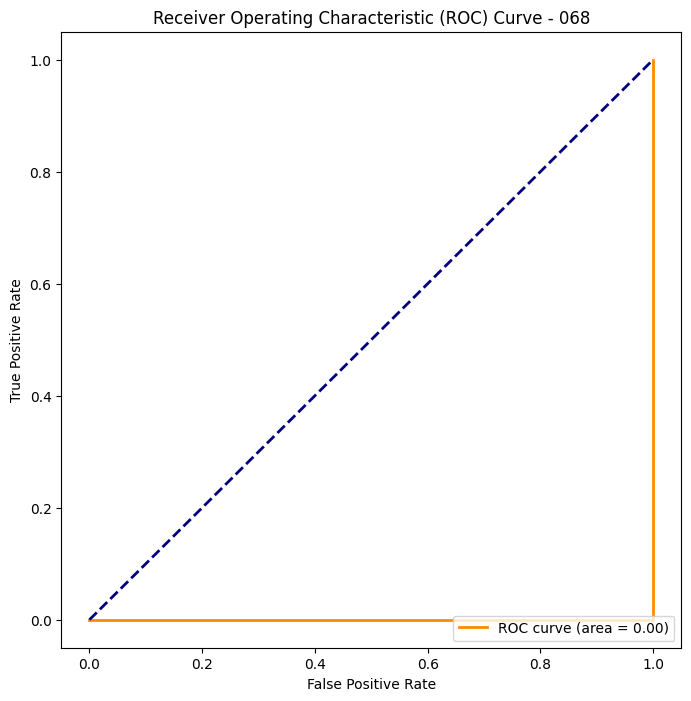


Signature: 069
FPR: [0.         0.33333333 1.         1.        ]
TPR: [0. 0. 0. 1.]
AUC: 0.0


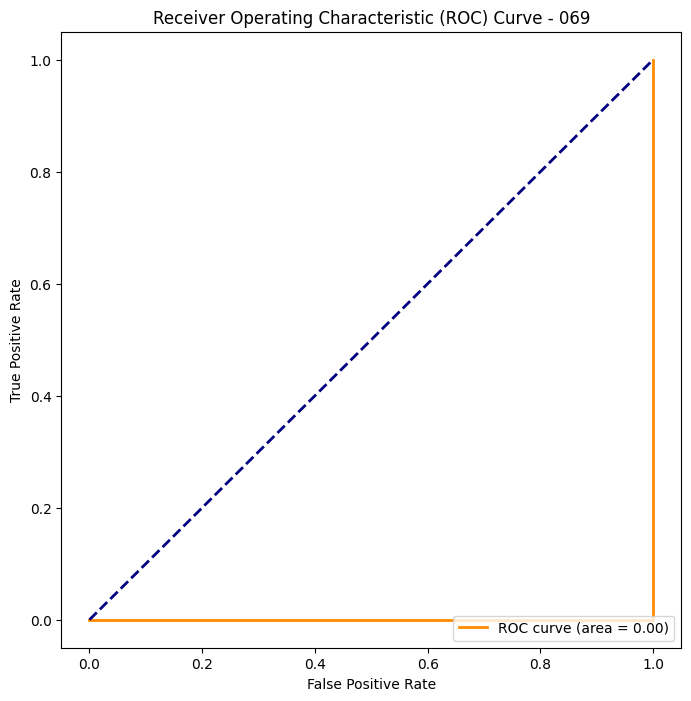

In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Combine distances and labels into tuples for each set of data
data_sets = zip(normalized_euclidean_distances, euclidean_actual_labels)

# Plot ROC curve for each set of data
plt.figure(figsize=(8, 8))
for distances, labels in data_sets:
    data = list(zip(distances, labels))
    sorted_data = sorted(set(data), key=lambda x: x[0])
    sorted_distances, sorted_labels = zip(*sorted_data)
    fpr, tpr, _ = roc_curve(sorted_labels, sorted_distances)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Data Set (AUC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
